In [ ]:
import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
!pip install tensorflow==1.14.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()


In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))


In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 112       
_________________________________________________________________
dense_18 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [ ]:
model.layers[-2].output

<tf.Tensor 'dense_18/Relu:0' shape=(?, 16) dtype=float32>

In [ ]:
lrs = []
K2 = 0.
beta1 = 0.9
beta2=0.9
batch_size=32
num_classes=2
from tqdm import tqdm

In [ ]:
def lr_schedule(epoch):
    global K2

    Kz = 0.  # max penultimate activation
    S = 0.
    N=0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
        labels=y_train[start_i:end_i]
        norm_label=np.linalg.norm(np.array(labels))

    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if norm_label < N:
          norm_label=N

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ
    
    K_ = (1/batch_size)*(max_wt+norm_label)*Kz
    S_ = (1/batch_size)*(max_wt+norm_label)*S
    
    K2 = beta1*K2 + (1-beta1)*K_
    S = beta2*S + (1-beta2)*S_

    lr = (np.sqrt(S)+K.epsilon())/K2
    print('norm+label =', norm_label, 'max_wt =', max_wt, 'Kz =', Kz, 'K2 =', K2)
    lrs.append(lr)
    print('Epoch', epoch+1, 'LR =', lr)
    return lr

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

In [ ]:
history=model.fit(x_train, y_train, epochs = 500, batch_size = 32,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

  0%|          | 0/13 [00:00<?, ?it/s]

Train on 404 samples, validate on 102 samples
Epoch 1/500


100%|██████████| 13/13 [00:00<00:00, 391.26it/s]


norm+label = 91.17159645415889 max_wt = 3.2141376 Kz = 473.14523 K2 = 139.55675038690498
Epoch 1 LR = 1.3588690807897148
404/404 [==============================] - 0s 936us/step - loss: 19239538171.2547 - mae: 39280.5391 - val_loss: 170162.6881 - val_mae: 291.8056


100%|██████████| 13/13 [00:00<00:00, 1565.67it/s]

Epoch 2/500
norm+label = 91.17159645415889 max_wt = 30.344332 Kz = 441.38565 K2 = 293.21165981401026
Epoch 2 LR = 0.8241827435729386
404/404 [==============================] - 0s 103us/step - loss: 115022.8201 - mae: 222.0155 - val_loss: 38390.9559 - val_mae: 113.0259



100%|██████████| 13/13 [00:00<00:00, 1445.35it/s]

Epoch 3/500
norm+label = 91.17159645415889 max_wt = 30.344084 Kz = 224.32857 K2 = 349.0762390752925
Epoch 3 LR = 0.413045706630221
404/404 [==============================] - 0s 106us/step - loss: 33205.1992 - mae: 107.7087 - val_loss: 18352.4973 - val_mae: 77.1555



100%|██████████| 13/13 [00:00<00:00, 1353.84it/s]

Epoch 4/500
norm+label = 91.17159645415889 max_wt = 30.34398 Kz = 155.5991 K2 = 373.2552250555238
Epoch 4 LR = 0.30637908087813537
404/404 [==============================] - 0s 115us/step - loss: 15452.6267 - mae: 72.7948 - val_loss: 10132.0275 - val_mae: 58.7007



100%|██████████| 13/13 [00:00<00:00, 1375.63it/s]

Epoch 5/500
norm+label = 91.17159645415889 max_wt = 30.343893 Kz = 120.01987 K2 = 381.5055553061716
Epoch 5 LR = 0.24838660673025295
404/404 [==============================] - 0s 99us/step - loss: 8273.4888 - mae: 54.2335 - val_loss: 5910.3321 - val_mae: 46.4053
Epoch 6/500



100%|██████████| 13/13 [00:00<00:00, 1163.94it/s]


norm+label = 91.17159645415889 max_wt = 30.34381 Kz = 97.729935 K2 = 380.4665393119419
Epoch 6 LR = 0.20650434933870446
404/404 [==============================] - 0s 129us/step - loss: 4892.2281 - mae: 43.3925 - val_loss: 3970.2614 - val_mae: 40.0113
Epoch 7/500


100%|██████████| 13/13 [00:00<00:00, 1733.96it/s]

norm+label = 91.17159645415889 max_wt = 30.343725 Kz = 80.29141 K2 = 372.9093753762568
Epoch 7 LR = 0.17814364492396215
404/404 [==============================] - 0s 120us/step - loss: 3123.0993 - mae: 37.9536 - val_loss: 2733.6654 - val_mae: 36.1365



100%|██████████| 13/13 [00:00<00:00, 1328.41it/s]

Epoch 8/500
norm+label = 91.17159645415889 max_wt = 30.343647 Kz = 62.22187 K2 = 359.2462682534564
Epoch 8 LR = 0.15073855869531436
404/404 [==============================] - 0s 102us/step - loss: 2048.1108 - mae: 33.0820 - val_loss: 1782.2956 - val_mae: 31.8800
Epoch 9/500



100%|██████████| 13/13 [00:00<00:00, 1390.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343575 Kz = 44.846428 K2 = 340.3513956660763
Epoch 9 LR = 0.12351122043519193
404/404 [==============================] - 0s 128us/step - loss: 1293.7083 - mae: 28.4903 - val_loss: 1050.5784 - val_mae: 26.8328



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/500


100%|██████████| 13/13 [00:00<00:00, 878.25it/s]

norm+label = 91.17159645415889 max_wt = 30.343517 Kz = 31.252768 K2 = 318.184017367101
Epoch 10 LR = 0.09269899002084418
 32/404 [=>............................] - ETA: 0s - loss: 756.1149 - mae: 25.6322

404/404 [==============================] - 0s 146us/step - loss: 797.9177 - mae: 23.8665 - val_loss: 711.3788 - val_mae: 23.3766
Epoch 11/500


100%|██████████| 13/13 [00:00<00:00, 1532.62it/s]

norm+label = 91.17159645415889 max_wt = 30.343487 Kz = 21.233345 K2 = 294.4286521585044
Epoch 11 LR = 0.06826709791836112
404/404 [==============================] - 0s 107us/step - loss: 633.9452 - mae: 22.2462 - val_loss: 617.3274 - val_mae: 22.7232



100%|██████████| 13/13 [00:00<00:00, 1512.43it/s]

Epoch 12/500
norm+label = 91.17159645415889 max_wt = 30.343464 Kz = 13.673542 K2 = 270.17810345550635
Epoch 12 LR = 0.047895786706055946
404/404 [==============================] - 0s 106us/step - loss: 576.0594 - mae: 21.7554 - val_loss: 572.5074 - val_mae: 22.1169



100%|██████████| 13/13 [00:00<00:00, 1385.21it/s]

Epoch 13/500
norm+label = 91.17159645415889 max_wt = 30.343447 Kz = 7.7397976 K2 = 246.0993613557697
Epoch 13 LR = 0.029692444756043105
404/404 [==============================] - 0s 107us/step - loss: 547.4406 - mae: 21.3913 - val_loss: 558.8473 - val_mae: 21.8083



100%|██████████| 13/13 [00:00<00:00, 1457.99it/s]

Epoch 14/500
norm+label = 91.17159645415889 max_wt = 30.34344 Kz = 4.953463 K2 = 223.37042597642673
Epoch 14 LR = 0.020672079916146755
 32/404 [=>............................] - ETA: 0s - loss: 399.9586 - mae: 18.6518

404/404 [==============================] - 0s 105us/step - loss: 531.5489 - mae: 21.0958 - val_loss: 548.1079 - val_mae: 21.5607


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/500


100%|██████████| 13/13 [00:00<00:00, 1210.88it/s]

norm+label = 91.17159645415889 max_wt = 30.34343 Kz = 1.9860654 K2 = 201.78756083899066
Epoch 15 LR = 0.007247585663832551
 32/404 [=>............................] - ETA: 0s - loss: 659.5188 - mae: 23.3787

404/404 [==============================] - 0s 111us/step - loss: 519.3358 - mae: 20.8486 - val_loss: 543.2555 - val_mae: 21.4479
Epoch 16/500


100%|██████████| 13/13 [00:00<00:00, 1692.04it/s]


norm+label = 91.17159645415889 max_wt = 30.343428 Kz = 1.7616706 K2 = 182.27777176807433
Epoch 16 LR = 0.004542655374308716
404/404 [==============================] - 0s 113us/step - loss: 514.4812 - mae: 20.7346 - val_loss: 539.4001 - val_mae: 21.3578
Epoch 17/500


100%|██████████| 13/13 [00:00<00:00, 1443.48it/s]

norm+label = 91.17159645415889 max_wt = 30.343426 Kz = 1.8954235 K2 = 164.76975219289758
Epoch 17 LR = 0.004171475172306045
 32/404 [=>............................] - ETA: 0s - loss: 554.6462 - mae: 21.4669

404/404 [==============================] - 0s 118us/step - loss: 510.4247 - mae: 20.6352 - val_loss: 535.1521 - val_mae: 21.2581


100%|██████████| 13/13 [00:00<00:00, 1296.32it/s]

Epoch 18/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 2.2088897 K2 = 149.13156847205784
Epoch 18 LR = 0.005263965784450714
404/404 [==============================] - 0s 110us/step - loss: 505.2813 - mae: 20.5103 - val_loss: 528.9112 - val_mae: 21.1108



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/500


100%|██████████| 13/13 [00:00<00:00, 1350.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 2.8208983 K2 = 135.28960385456222
Epoch 19 LR = 0.00730006210584319
404/404 [==============================] - 0s 107us/step - loss: 497.9255 - mae: 20.3291 - val_loss: 519.7139 - val_mae: 20.8919



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/500


100%|██████████| 13/13 [00:00<00:00, 1045.84it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 3.8103392 K2 = 123.20756049016052
Epoch 20 LR = 0.010560122104924493
 32/404 [=>............................] - ETA: 0s - loss: 541.5859 - mae: 21.3853

404/404 [==============================] - 0s 131us/step - loss: 487.1649 - mae: 20.0595 - val_loss: 506.1419 - val_mae: 20.5645
Epoch 21/500


100%|██████████| 13/13 [00:00<00:00, 1505.83it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 5.3706546 K2 = 112.92622694321189
Epoch 21 LR = 0.015798979138401746
 32/404 [=>............................] - ETA: 0s - loss: 480.1682 - mae: 20.3361

404/404 [==============================] - 0s 118us/step - loss: 471.0647 - mae: 19.6596 - val_loss: 485.8520 - val_mae: 20.0651


100%|██████████| 13/13 [00:00<00:00, 1428.43it/s]

Epoch 22/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 7.8218565 K2 = 104.60383253391012
Epoch 22 LR = 0.02429359226979646
 32/404 [=>............................] - ETA: 0s - loss: 509.0052 - mae: 20.1523

404/404 [==============================] - 0s 111us/step - loss: 447.0627 - mae: 19.0375 - val_loss: 455.3544 - val_mae: 19.2902
Epoch 23/500


100%|██████████| 13/13 [00:00<00:00, 1530.51it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 11.661762 K2 = 98.5718220148968
Epoch 23 LR = 0.0377698005051155
 32/404 [=>............................] - ETA: 0s - loss: 498.0195 - mae: 19.4899

404/404 [==============================] - 0s 115us/step - loss: 410.2349 - mae: 18.0422 - val_loss: 406.8684 - val_mae: 17.9896
Epoch 24/500


100%|██████████| 13/13 [00:00<00:00, 1716.43it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 17.915152 K2 = 95.51763984412561
Epoch 24 LR = 0.05868789076043159
404/404 [==============================] - 0s 107us/step - loss: 347.7291 - mae: 16.2264 - val_loss: 317.5016 - val_mae: 15.3930



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/500


100%|██████████| 13/13 [00:00<00:00, 1325.25it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.621721 K2 = 96.83452911219804
Epoch 25 LR = 0.09030367455532762
404/404 [==============================] - 0s 112us/step - loss: 224.7442 - mae: 12.0291 - val_loss: 143.3963 - val_mae: 9.3849
Epoch 26/500



100%|██████████| 13/13 [00:00<00:00, 1336.94it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.893154 K2 = 104.5782873177323
Epoch 26 LR = 0.1334532942768283
404/404 [==============================] - 0s 127us/step - loss: 96.1854 - mae: 6.9217 - val_loss: 83.3672 - val_mae: 6.5595


100%|██████████| 13/13 [00:00<00:00, 1953.36it/s]


Epoch 27/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 56.498318 K2 = 115.57481553702549
Epoch 27 LR = 0.14907837445281114
404/404 [==============================] - 0s 116us/step - loss: 85.4303 - mae: 6.7794 - val_loss: 91.7026 - val_mae: 6.8069
Epoch 28/500


100%|██████████| 13/13 [00:00<00:00, 1421.69it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 53.793613 K2 = 124.44462157173224
Epoch 28 LR = 0.13177783171755014
404/404 [==============================] - 0s 108us/step - loss: 87.1868 - mae: 6.7633 - val_loss: 86.4770 - val_mae: 6.5635



100%|██████████| 13/13 [00:00<00:00, 1543.86it/s]


Epoch 29/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 54.83645 K2 = 132.8234474555321
Epoch 29 LR = 0.12582092716156165
404/404 [==============================] - 0s 111us/step - loss: 84.9460 - mae: 6.6893 - val_loss: 83.5680 - val_mae: 6.7103


100%|██████████| 13/13 [00:00<00:00, 1604.55it/s]


Epoch 30/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 56.242283 K2 = 140.89823441065417
Epoch 30 LR = 0.12161413461572936
404/404 [==============================] - 0s 109us/step - loss: 87.7176 - mae: 6.8987 - val_loss: 98.3881 - val_mae: 7.1799
Epoch 31/500


100%|██████████| 13/13 [00:00<00:00, 1100.73it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 52.269077 K2 = 146.6567796857385
Epoch 31 LR = 0.10851224580273812
404/404 [==============================] - 0s 121us/step - loss: 90.0755 - mae: 6.8664 - val_loss: 83.2863 - val_mae: 6.5738
Epoch 32/500



100%|██████████| 13/13 [00:00<00:00, 1525.16it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 53.45219 K2 = 152.2887392212373
Epoch 32 LR = 0.10681565670845453
404/404 [==============================] - 0s 121us/step - loss: 87.6852 - mae: 6.7347 - val_loss: 84.0072 - val_mae: 6.7789


100%|██████████| 13/13 [00:00<00:00, 1251.14it/s]

Epoch 33/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 53.305878 K2 = 157.30194282704343
Epoch 33 LR = 0.10309941088464054
404/404 [==============================] - 0s 123us/step - loss: 89.5102 - mae: 6.9102 - val_loss: 90.9189 - val_mae: 6.7685



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/500


100%|██████████| 13/13 [00:00<00:00, 1260.28it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 50.81154 K2 = 160.86663965692952
Epoch 34 LR = 0.09608218362874832
 32/404 [=>............................] - ETA: 0s - loss: 111.0718 - mae: 6.8610

404/404 [==============================] - 0s 120us/step - loss: 88.6104 - mae: 6.8336 - val_loss: 86.4032 - val_mae: 6.5606


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/500


100%|██████████| 13/13 [00:00<00:00, 1249.71it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 50.725193 K2 = 164.0420783783286
Epoch 35 LR = 0.09404358189113293
404/404 [==============================] - 0s 108us/step - loss: 85.2443 - mae: 6.6485 - val_loss: 86.2675 - val_mae: 6.5554



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/500


100%|██████████| 13/13 [00:00<00:00, 1234.88it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 50.498898 K2 = 166.8140410439157
Epoch 36 LR = 0.09206220439104415
404/404 [==============================] - 0s 113us/step - loss: 88.5437 - mae: 6.8602 - val_loss: 84.9913 - val_mae: 6.8981



100%|██████████| 13/13 [00:00<00:00, 1554.20it/s]

Epoch 37/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 51.367725 K2 = 169.63873128719723
Epoch 37 LR = 0.0920691985132299
404/404 [==============================] - 0s 118us/step - loss: 87.4863 - mae: 6.8102 - val_loss: 85.2479 - val_mae: 6.9276
Epoch 38/500



100%|██████████| 13/13 [00:00<00:00, 1306.64it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 51.07066 K2 = 172.06814641614557
Epoch 38 LR = 0.09023858526111819
404/404 [==============================] - 0s 116us/step - loss: 87.1263 - mae: 6.7973 - val_loss: 83.6941 - val_mae: 6.5339
Epoch 39/500



100%|██████████| 13/13 [00:00<00:00, 1603.28it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 49.727486 K2 = 173.7445706149195
Epoch 39 LR = 0.08701469012319045
404/404 [==============================] - 0s 112us/step - loss: 88.7122 - mae: 6.8295 - val_loss: 87.3633 - val_mae: 6.6012


100%|██████████| 13/13 [00:00<00:00, 1530.94it/s]


Epoch 40/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 48.6157 K2 = 174.831169003727
Epoch 40 LR = 0.08453620432807805
404/404 [==============================] - 0s 111us/step - loss: 85.6347 - mae: 6.6804 - val_loss: 84.9579 - val_mae: 6.5189
Epoch 41/500


100%|██████████| 13/13 [00:00<00:00, 1456.28it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 48.704685 K2 = 175.84289839092358
Epoch 41 LR = 0.08420054177084142
404/404 [==============================] - 0s 122us/step - loss: 86.7487 - mae: 6.7235 - val_loss: 83.8144 - val_mae: 6.7511


100%|██████████| 13/13 [00:00<00:00, 1897.15it/s]


Epoch 42/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 49.41169 K2 = 177.0219288140681
Epoch 42 LR = 0.08485049142671779
404/404 [==============================] - 0s 101us/step - loss: 83.1809 - mae: 6.6819 - val_loss: 83.3442 - val_mae: 6.6559
Epoch 43/500


100%|██████████| 13/13 [00:00<00:00, 1907.97it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 48.90822 K2 = 177.89187077523246
Epoch 43 LR = 0.0835742002667332
404/404 [==============================] - 0s 126us/step - loss: 86.8057 - mae: 6.7488 - val_loss: 90.4377 - val_mae: 6.7460


100%|██████████| 13/13 [00:00<00:00, 1318.42it/s]


Epoch 44/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 46.987095 K2 = 177.94530178509208
Epoch 44 LR = 0.08026807190818872
404/404 [==============================] - 0s 113us/step - loss: 87.0706 - mae: 6.7185 - val_loss: 83.3487 - val_mae: 6.6574


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/500


100%|██████████| 13/13 [00:00<00:00, 1582.16it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 48.08991 K2 = 178.41216604288965
Epoch 45 LR = 0.08193643313251307
404/404 [==============================] - 0s 120us/step - loss: 87.3011 - mae: 6.7765 - val_loss: 83.3034 - val_mae: 6.6417



100%|██████████| 13/13 [00:00<00:00, 1883.97it/s]

Epoch 46/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 47.751778 K2 = 178.70394390814118
Epoch 46 LR = 0.08122904788714456
404/404 [==============================] - 0s 122us/step - loss: 86.3824 - mae: 6.8287 - val_loss: 86.5065 - val_mae: 6.5646



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/500


100%|██████████| 13/13 [00:00<00:00, 1146.54it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 46.42693 K2 = 178.46345350911062
Epoch 47 LR = 0.07908470026869906
404/404 [==============================] - 0s 113us/step - loss: 88.5501 - mae: 6.7676 - val_loss: 83.4385 - val_mae: 6.6827



100%|██████████| 13/13 [00:00<00:00, 1490.80it/s]

Epoch 48/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 47.213573 K2 = 178.54572796070687
Epoch 48 LR = 0.08039047508720967
404/404 [==============================] - 0s 111us/step - loss: 87.0982 - mae: 6.8217 - val_loss: 85.7780 - val_mae: 6.5369



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/500


100%|██████████| 13/13 [00:00<00:00, 1121.61it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.79587 K2 = 178.0814248001859
Epoch 49 LR = 0.07818601121308448
404/404 [==============================] - 0s 112us/step - loss: 86.9174 - mae: 6.6882 - val_loss: 83.2949 - val_mae: 6.5718



100%|██████████| 13/13 [00:00<00:00, 1379.60it/s]


Epoch 50/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 46.295563 K2 = 177.85330184060612
Epoch 50 LR = 0.07914333852446435
404/404 [==============================] - 0s 110us/step - loss: 86.0211 - mae: 6.7003 - val_loss: 86.1180 - val_mae: 6.5494
Epoch 51/500


100%|██████████| 13/13 [00:00<00:00, 1138.73it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.28756 K2 = 177.26521763465806
Epoch 51 LR = 0.0776824340490342
404/404 [==============================] - 0s 115us/step - loss: 87.7467 - mae: 6.8077 - val_loss: 83.8382 - val_mae: 6.7548
Epoch 52/500


100%|██████████| 13/13 [00:00<00:00, 1606.02it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 46.309956 K2 = 177.12418085350006
Epoch 52 LR = 0.07950339377287927
404/404 [==============================] - 0s 121us/step - loss: 87.9548 - mae: 6.8318 - val_loss: 83.2734 - val_mae: 6.5773


100%|██████████| 13/13 [00:00<00:00, 1379.11it/s]


Epoch 53/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.475983 K2 = 176.68055950787377
Epoch 53 LR = 0.07827726002594472
404/404 [==============================] - 0s 107us/step - loss: 87.3514 - mae: 6.7834 - val_loss: 84.4107 - val_mae: 6.5137
Epoch 54/500


100%|██████████| 13/13 [00:00<00:00, 1534.04it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 44.749638 K2 = 176.0054820624881
Epoch 54 LR = 0.07733055888816101
404/404 [==============================] - 0s 106us/step - loss: 86.1854 - mae: 6.7655 - val_loss: 88.5203 - val_mae: 6.6534
Epoch 55/500



100%|██████████| 13/13 [00:00<00:00, 1522.26it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 43.907604 K2 = 175.07816328658163
Epoch 55 LR = 0.07628461096976824
404/404 [==============================] - 0s 111us/step - loss: 87.9257 - mae: 6.8528 - val_loss: 83.8133 - val_mae: 6.7509
Epoch 56/500


100%|██████████| 13/13 [00:00<00:00, 1575.94it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.32138 K2 = 174.78043597471367
Epoch 56 LR = 0.07887801148263289
404/404 [==============================] - 0s 122us/step - loss: 87.1422 - mae: 6.7706 - val_loss: 83.5917 - val_mae: 6.7147
Epoch 57/500


100%|██████████| 13/13 [00:00<00:00, 1505.62it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 45.042053 K2 = 174.4064111634738
Epoch 57 LR = 0.07856698176544367
404/404 [==============================] - 0s 131us/step - loss: 86.4110 - mae: 6.7437 - val_loss: 83.4059 - val_mae: 6.5550


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 58/500


100%|██████████| 13/13 [00:00<00:00, 1224.48it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 44.26613 K2 = 173.77514350974042
Epoch 58 LR = 0.07750524586188147
404/404 [==============================] - 0s 105us/step - loss: 88.8796 - mae: 6.8284 - val_loss: 85.1167 - val_mae: 6.5212



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 59/500


100%|██████████| 13/13 [00:00<00:00, 1211.47it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 43.386642 K2 = 172.87303146717173
Epoch 59 LR = 0.07637933374805773
404/404 [==============================] - 0s 108us/step - loss: 86.1930 - mae: 6.7878 - val_loss: 87.1038 - val_mae: 6.5897



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 60/500


100%|██████████| 13/13 [00:00<00:00, 1137.66it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 42.93606 K2 = 171.89002965891967
Epoch 60 LR = 0.07602544053694224
404/404 [==============================] - 0s 106us/step - loss: 87.4462 - mae: 6.7472 - val_loss: 83.3987 - val_mae: 6.5557



100%|██████████| 13/13 [00:00<00:00, 1497.06it/s]

Epoch 61/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 43.49621 K2 = 171.2180348842325
Epoch 61 LR = 0.07733004914748873
404/404 [==============================] - 0s 106us/step - loss: 86.9657 - mae: 6.7675 - val_loss: 83.9208 - val_mae: 6.5248
Epoch 62/500



100%|██████████| 13/13 [00:00<00:00, 1397.13it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 43.03204 K2 = 170.43697880388075
Epoch 62 LR = 0.07686867429801518
404/404 [==============================] - 0s 133us/step - loss: 87.3763 - mae: 6.7563 - val_loss: 83.4568 - val_mae: 6.6870
Epoch 63/500


100%|██████████| 13/13 [00:00<00:00, 1316.32it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 43.53704 K2 = 169.92579462857137
Epoch 63 LR = 0.07801123974893069
404/404 [==============================] - 0s 121us/step - loss: 86.5885 - mae: 6.8266 - val_loss: 92.1862 - val_mae: 6.8314



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 64/500


100%|██████████| 13/13 [00:00<00:00, 1050.64it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.437843 K2 = 168.6685913296231
Epoch 64 LR = 0.07482600133792851
 32/404 [=>............................] - ETA: 0s - loss: 86.6051 - mae: 6.5446

404/404 [==============================] - 0s 119us/step - loss: 87.2145 - mae: 6.7337 - val_loss: 83.7433 - val_mae: 6.5317


100%|██████████| 13/13 [00:00<00:00, 1525.20it/s]

Epoch 65/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 42.43448 K2 = 167.91556515856254
Epoch 65 LR = 0.07697812758371322
404/404 [==============================] - 0s 99us/step - loss: 86.8096 - mae: 6.7809 - val_loss: 83.3672 - val_mae: 6.5595



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 66/500


100%|██████████| 13/13 [00:00<00:00, 1145.62it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 42.442146 K2 = 167.24075323417517
Epoch 66 LR = 0.07731377261938283
404/404 [==============================] - 0s 119us/step - loss: 85.8772 - mae: 6.7383 - val_loss: 84.9378 - val_mae: 6.5186



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 67/500


100%|██████████| 13/13 [00:00<00:00, 1163.99it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.72864 K2 = 166.36248016100052
Epoch 67 LR = 0.0764326509570334
404/404 [==============================] - 0s 111us/step - loss: 86.9773 - mae: 6.7155 - val_loss: 84.6065 - val_mae: 6.5137



100%|██████████| 13/13 [00:00<00:00, 1489.66it/s]


Epoch 68/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.53666 K2 = 165.49913211592713
Epoch 68 LR = 0.07649730017407232
404/404 [==============================] - 0s 119us/step - loss: 86.7956 - mae: 6.7580 - val_loss: 85.4942 - val_mae: 6.5292
Epoch 69/500


100%|██████████| 13/13 [00:00<00:00, 1568.82it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.14691 K2 = 164.57411828189194
Epoch 69 LR = 0.07622324751292157
404/404 [==============================] - 0s 113us/step - loss: 88.0801 - mae: 6.8469 - val_loss: 85.8527 - val_mae: 6.5396



100%|██████████| 13/13 [00:00<00:00, 1362.91it/s]

Epoch 70/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 40.87363 K2 = 163.637831587201
Epoch 70 LR = 0.07616824253840251
404/404 [==============================] - 0s 130us/step - loss: 86.1089 - mae: 6.6853 - val_loss: 88.2529 - val_mae: 6.6403



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 71/500


100%|██████████| 13/13 [00:00<00:00, 1489.98it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 40.350937 K2 = 162.5966887883887
Epoch 71 LR = 0.07569434293130828
404/404 [==============================] - 0s 108us/step - loss: 86.9777 - mae: 6.8249 - val_loss: 84.6869 - val_mae: 6.5146



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 72/500


100%|██████████| 13/13 [00:00<00:00, 1362.84it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 40.689407 K2 = 161.78818915912515
Epoch 72 LR = 0.07672679757633236
404/404 [==============================] - 0s 108us/step - loss: 86.6358 - mae: 6.6979 - val_loss: 86.2747 - val_mae: 6.5556



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 73/500


100%|██████████| 13/13 [00:00<00:00, 1254.94it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 40.2043 K2 = 160.8763274983641
Epoch 73 LR = 0.07626291644537746
404/404 [==============================] - 0s 115us/step - loss: 85.3868 - mae: 6.6003 - val_loss: 87.6121 - val_mae: 7.1752



100%|██████████| 13/13 [00:00<00:00, 1537.63it/s]

Epoch 74/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 42.21197 K2 = 160.81803395867783
Epoch 74 LR = 0.08008136234512343
404/404 [==============================] - 0s 99us/step - loss: 86.3445 - mae: 6.7886 - val_loss: 92.6720 - val_mae: 6.8581
Epoch 75/500



100%|██████████| 13/13 [00:00<00:00, 1489.29it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 39.057804 K2 = 159.56782387193655
Epoch 75 LR = 0.07474528016583579
 32/404 [=>............................] - ETA: 0s - loss: 86.2262 - mae: 5.9021

404/404 [==============================] - 0s 114us/step - loss: 85.8804 - mae: 6.6871 - val_loss: 83.8584 - val_mae: 6.7578
Epoch 76/500


100%|██████████| 13/13 [00:00<00:00, 1623.96it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.089676 K2 = 159.21420648915358
Epoch 76 LR = 0.07879030589256701
 32/404 [=>............................] - ETA: 0s - loss: 83.0510 - mae: 7.2953

404/404 [==============================] - 0s 118us/step - loss: 86.0605 - mae: 6.7192 - val_loss: 85.7370 - val_mae: 6.9850
Epoch 77/500


100%|██████████| 13/13 [00:00<00:00, 1531.71it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.371223 K2 = 159.00286414406736
Epoch 77 LR = 0.07944551409143538
404/404 [==============================] - 0s 128us/step - loss: 85.8059 - mae: 6.7965 - val_loss: 86.6229 - val_mae: 7.0765
Epoch 78/500

100%|██████████| 13/13 [00:00<00:00, 1315.30it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 41.325596 K2 = 158.79532966470748
Epoch 78 LR = 0.07948066427617101
404/404 [==============================] - 0s 121us/step - loss: 86.5211 - mae: 6.8162 - val_loss: 83.7036 - val_mae: 6.7337



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 79/500


100%|██████████| 13/13 [00:00<00:00, 1273.11it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 40.438305 K2 = 158.27161370091855
Epoch 79 LR = 0.07807257685504777
404/404 [==============================] - 0s 108us/step - loss: 87.9677 - mae: 6.9323 - val_loss: 83.7878 - val_mae: 6.5299



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 80/500


100%|██████████| 13/13 [00:00<00:00, 1116.65it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 39.398556 K2 = 157.40544077563123
Epoch 80 LR = 0.07653023000722026
404/404 [==============================] - 0s 116us/step - loss: 86.0900 - mae: 6.6544 - val_loss: 83.2443 - val_mae: 6.5961



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 81/500


100%|██████████| 13/13 [00:00<00:00, 1193.10it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 39.67918 K2 = 156.7324478878855
Epoch 81 LR = 0.07741420244467877
404/404 [==============================] - 0s 120us/step - loss: 85.9109 - mae: 6.7965 - val_loss: 91.4826 - val_mae: 6.7958



100%|██████████| 13/13 [00:00<00:00, 1428.50it/s]


Epoch 82/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 37.846558 K2 = 155.43084440236152
Epoch 82 LR = 0.07451875693062388
404/404 [==============================] - 0s 125us/step - loss: 87.8975 - mae: 6.7754 - val_loss: 83.2900 - val_mae: 6.5729


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 83/500


100%|██████████| 13/13 [00:00<00:00, 1165.78it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 39.200474 K2 = 154.7735298612073
Epoch 83 LR = 0.07750310207610295
 32/404 [=>............................] - ETA: 0s - loss: 73.7375 - mae: 6.8011

404/404 [==============================] - 0s 122us/step - loss: 87.8961 - mae: 6.9024 - val_loss: 84.8015 - val_mae: 6.5165
Epoch 84/500


100%|██████████| 13/13 [00:00<00:00, 1268.43it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.50707 K2 = 153.91863695840973
Epoch 84 LR = 0.07658456507716685
 32/404 [=>............................] - ETA: 0s - loss: 75.8775 - mae: 6.6875

404/404 [==============================] - 0s 133us/step - loss: 85.4339 - mae: 6.6086 - val_loss: 83.7630 - val_mae: 6.5309


100%|██████████| 13/13 [00:00<00:00, 1482.41it/s]

Epoch 85/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.707077 K2 = 153.2251834204361
Epoch 85 LR = 0.07733820608808965
 32/404 [=>............................] - ETA: 0s - loss: 123.9860 - mae: 7.8740

404/404 [==============================] - 0s 121us/step - loss: 86.7276 - mae: 6.7840 - val_loss: 83.2503 - val_mae: 6.5880


100%|██████████| 13/13 [00:00<00:00, 1394.81it/s]

Epoch 86/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.888416 K2 = 152.6699359998083
Epoch 86 LR = 0.07800151317189893
 32/404 [=>............................] - ETA: 0s - loss: 65.5830 - mae: 6.1181

404/404 [==============================] - 0s 110us/step - loss: 85.7293 - mae: 6.7517 - val_loss: 83.5808 - val_mae: 6.5410
Epoch 87/500


100%|██████████| 13/13 [00:00<00:00, 1496.65it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.439857 K2 = 151.9998800944227
Epoch 87 LR = 0.07747611775936275
404/404 [==============================] - 0s 103us/step - loss: 86.1130 - mae: 6.7308 - val_loss: 84.8517 - val_mae: 6.5172



100%|██████████| 13/13 [00:00<00:00, 1661.01it/s]


Epoch 88/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 37.85019 K2 = 151.1729124287166
Epoch 88 LR = 0.07674921198728928
404/404 [==============================] - 0s 112us/step - loss: 86.3438 - mae: 6.6906 - val_loss: 83.5851 - val_mae: 6.5407
Epoch 89/500


100%|██████████| 13/13 [00:00<00:00, 1471.17it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.125935 K2 = 150.5333515511032
Epoch 89 LR = 0.07764597526405255
 32/404 [=>............................] - ETA: 0s - loss: 99.0738 - mae: 7.4611

404/404 [==============================] - 0s 106us/step - loss: 85.7348 - mae: 6.7298 - val_loss: 85.4015 - val_mae: 6.9461


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 90/500


100%|██████████| 13/13 [00:00<00:00, 1232.81it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 39.169064 K2 = 150.35385875385307
Epoch 90 LR = 0.07984931577126379
404/404 [==============================] - 0s 104us/step - loss: 86.2109 - mae: 6.8601 - val_loss: 85.5995 - val_mae: 6.5319


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 91/500


100%|██████████| 13/13 [00:00<00:00, 1339.18it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 37.30582 K2 = 149.4847776629416
Epoch 91 LR = 0.07657418450268619
404/404 [==============================] - 0s 113us/step - loss: 85.1949 - mae: 6.7129 - val_loss: 87.2771 - val_mae: 6.5974
Epoch 92/500


100%|██████████| 13/13 [00:00<00:00, 1700.59it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.860054 K2 = 148.53333180894907
Epoch 92 LR = 0.07618499887868045
404/404 [==============================] - 0s 127us/step - loss: 85.3873 - mae: 6.7756 - val_loss: 92.4007 - val_mae: 6.8433


100%|██████████| 13/13 [00:00<00:00, 1599.05it/s]


Epoch 93/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.14059 K2 = 147.4038255297846
Epoch 93 LR = 0.0753147134421833
404/404 [==============================] - 0s 107us/step - loss: 86.5724 - mae: 6.7660 - val_loss: 86.2060 - val_mae: 6.5529


100%|██████████| 13/13 [00:00<00:00, 1749.53it/s]

Epoch 94/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.71484 K2 = 146.6053321016791
Epoch 94 LR = 0.07694133294184818
404/404 [==============================] - 0s 107us/step - loss: 86.8256 - mae: 6.7674 - val_loss: 84.9416 - val_mae: 6.8922



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 95/500


100%|██████████| 13/13 [00:00<00:00, 1115.48it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.32321 K2 = 146.49744215381614
Epoch 95 LR = 0.08033041281363035
404/404 [==============================] - 0s 116us/step - loss: 86.8088 - mae: 6.7850 - val_loss: 85.1446 - val_mae: 6.9160



100%|██████████| 13/13 [00:00<00:00, 1304.11it/s]

Epoch 96/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 38.215668 K2 = 146.35950306105968
Epoch 96 LR = 0.08021096004880224
404/404 [==============================] - 0s 112us/step - loss: 86.6369 - mae: 6.7308 - val_loss: 83.2517 - val_mae: 6.5870



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 97/500


100%|██████████| 13/13 [00:00<00:00, 1363.18it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 37.196323 K2 = 145.84827773092275
Epoch 97 LR = 0.0784203697892779
404/404 [==============================] - 0s 129us/step - loss: 84.9321 - mae: 6.7140 - val_loss: 86.1590 - val_mae: 6.5510


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 98/500


100%|██████████| 13/13 [00:00<00:00, 1109.83it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.139774 K2 = 144.9869668651692
Epoch 98 LR = 0.07671155419164688
404/404 [==============================] - 0s 110us/step - loss: 87.2836 - mae: 6.7932 - val_loss: 83.6120 - val_mae: 6.5390



100%|██████████| 13/13 [00:00<00:00, 1494.48it/s]


Epoch 99/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.59549 K2 = 144.38483783374085
Epoch 99 LR = 0.07802128986634131
404/404 [==============================] - 0s 115us/step - loss: 85.6975 - mae: 6.7729 - val_loss: 83.2678 - val_mae: 6.6241


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 100/500


100%|██████████| 13/13 [00:00<00:00, 1215.88it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.918465 K2 = 143.9655664959678
Epoch 100 LR = 0.0789487336263564
404/404 [==============================] - 0s 111us/step - loss: 85.8257 - mae: 6.7223 - val_loss: 83.9979 - val_mae: 6.7777



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 101/500


100%|██████████| 13/13 [00:00<00:00, 1125.31it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 37.228596 K2 = 143.7059897408166
Epoch 101 LR = 0.07976075093201047
404/404 [==============================] - 0s 116us/step - loss: 84.4676 - mae: 6.7461 - val_loss: 90.3521 - val_mae: 6.7420
Epoch 102/500



100%|██████████| 13/13 [00:00<00:00, 1212.95it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.957153 K2 = 142.60982575192895
Epoch 102 LR = 0.07562171983396046
404/404 [==============================] - 0s 116us/step - loss: 85.6992 - mae: 6.6534 - val_loss: 84.8262 - val_mae: 6.5168



100%|██████████| 13/13 [00:00<00:00, 1578.63it/s]

Epoch 103/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.68015 K2 = 141.89782455010285
Epoch 103 LR = 0.07756263894953352
404/404 [==============================] - 0s 124us/step - loss: 85.6269 - mae: 6.6912 - val_loss: 84.7615 - val_mae: 6.5158



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 104/500


100%|██████████| 13/13 [00:00<00:00, 1178.38it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.57411 K2 = 141.21675606611763
Epoch 104 LR = 0.07773835218988052
404/404 [==============================] - 0s 109us/step - loss: 86.6414 - mae: 6.7797 - val_loss: 84.9490 - val_mae: 6.5187



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 105/500


100%|██████████| 13/13 [00:00<00:00, 1150.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.39007 K2 = 140.53390952663227
Epoch 105 LR = 0.0777550014985235
404/404 [==============================] - 0s 113us/step - loss: 87.3468 - mae: 6.7622 - val_loss: 83.5887 - val_mae: 6.5405



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 106/500


100%|██████████| 13/13 [00:00<00:00, 801.31it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.65191 K2 = 140.0187761693829
Epoch 106 LR = 0.07864253320155001
404/404 [==============================] - 0s 123us/step - loss: 86.0776 - mae: 6.7136 - val_loss: 83.2653 - val_mae: 6.5802



100%|██████████| 13/13 [00:00<00:00, 1536.33it/s]

Epoch 107/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.802162 K2 = 139.6122124987987
Epoch 107 LR = 0.07922092707594187
404/404 [==============================] - 0s 111us/step - loss: 84.8331 - mae: 6.6740 - val_loss: 87.1241 - val_mae: 7.1258



100%|██████████| 13/13 [00:00<00:00, 1553.76it/s]

Epoch 108/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 36.975403 K2 = 139.69182507905663
Epoch 108 LR = 0.0817091415761052
 32/404 [=>............................] - ETA: 0s - loss: 107.9028 - mae: 8.7275

404/404 [==============================] - 0s 103us/step - loss: 86.6627 - mae: 6.7642 - val_loss: 83.4403 - val_mae: 6.5518
Epoch 109/500


100%|██████████| 13/13 [00:00<00:00, 1575.58it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.32855 K2 = 139.13810907028804
Epoch 109 LR = 0.07854596633688751
404/404 [==============================] - 0s 117us/step - loss: 87.4694 - mae: 6.7711 - val_loss: 88.5052 - val_mae: 6.6526
Epoch 110/500


100%|██████████| 13/13 [00:00<00:00, 1663.44it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.00878 K2 = 138.13860368244207
Epoch 110 LR = 0.07630311056959055
 32/404 [=>............................] - ETA: 0s - loss: 87.2563 - mae: 6.8041

404/404 [==============================] - 0s 110us/step - loss: 86.1759 - mae: 6.7137 - val_loss: 83.2458 - val_mae: 6.6054
Epoch 111/500


100%|██████████| 13/13 [00:00<00:00, 1557.75it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.34605 K2 = 137.746855861322
Epoch 111 LR = 0.0794510279045947
 32/404 [=>............................] - ETA: 0s - loss: 79.9121 - mae: 6.4760

404/404 [==============================] - 0s 118us/step - loss: 85.5170 - mae: 6.8323 - val_loss: 96.0828 - val_mae: 7.0529
Epoch 112/500


100%|██████████| 13/13 [00:00<00:00, 1236.58it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.97237 K2 = 136.49291473692878
Epoch 112 LR = 0.07501372411269092
404/404 [==============================] - 0s 139us/step - loss: 86.3358 - mae: 6.7386 - val_loss: 90.2633 - val_mae: 6.7377


Epoch 113/500


100%|██████████| 13/13 [00:00<00:00, 1061.97it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.469475 K2 = 135.55313547809953
Epoch 113 LR = 0.07666000830872853
 32/404 [=>............................] - ETA: 0s - loss: 42.0877 - mae: 4.8633

404/404 [==============================] - 0s 156us/step - loss: 85.8387 - mae: 6.6880 - val_loss: 85.2147 - val_mae: 6.5231


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 114/500


100%|██████████| 13/13 [00:00<00:00, 1168.43it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.139854 K2 = 134.96190038077904
Epoch 114 LR = 0.07851315698433042
404/404 [==============================] - 0s 126us/step - loss: 87.2264 - mae: 6.8012 - val_loss: 83.2523 - val_mae: 6.6130


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 115/500


100%|██████████| 13/13 [00:00<00:00, 1180.57it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.89431 K2 = 134.71628155402013
Epoch 115 LR = 0.08037799112603367
 32/404 [=>............................] - ETA: 0s - loss: 131.5430 - mae: 9.3933

404/404 [==============================] - 0s 127us/step - loss: 86.9147 - mae: 6.7643 - val_loss: 84.5092 - val_mae: 6.8401


100%|██████████| 13/13 [00:00<00:00, 1417.62it/s]

Epoch 116/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 35.388786 K2 = 134.68299429700616
Epoch 116 LR = 0.08153140548916793
 32/404 [=>............................] - ETA: 0s - loss: 106.7325 - mae: 7.6952

404/404 [==============================] - 0s 109us/step - loss: 84.7377 - mae: 6.7623 - val_loss: 84.6945 - val_mae: 6.5147


100%|██████████| 13/13 [00:00<00:00, 1277.43it/s]

Epoch 117/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.852726 K2 = 134.06974075765183
Epoch 117 LR = 0.07852549071024059
404/404 [==============================] - 0s 106us/step - loss: 86.5380 - mae: 6.8910 - val_loss: 84.2174 - val_mae: 6.5173



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 118/500


100%|██████████| 13/13 [00:00<00:00, 1256.65it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.834232 K2 = 133.51078989554566
Epoch 118 LR = 0.07886360537365154
404/404 [==============================] - 0s 111us/step - loss: 85.8836 - mae: 6.7631 - val_loss: 83.3916 - val_mae: 6.5564



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 119/500


100%|██████████| 13/13 [00:00<00:00, 1109.15it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.110954 K2 = 133.11281497558477
Epoch 119 LR = 0.07975055384173461
 32/404 [=>............................] - ETA: 0s - loss: 83.9468 - mae: 6.1454

404/404 [==============================] - 0s 136us/step - loss: 86.8365 - mae: 6.8321 - val_loss: 84.3914 - val_mae: 6.5140


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 120/500


100%|██████████| 13/13 [00:00<00:00, 1246.79it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.553745 K2 = 132.5430460952617
Epoch 120 LR = 0.07888843279031293
404/404 [==============================] - 0s 104us/step - loss: 85.9808 - mae: 6.7088 - val_loss: 87.2465 - val_mae: 6.5961



100%|██████████| 13/13 [00:00<00:00, 1605.69it/s]

Epoch 121/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.868946 K2 = 131.7702122654726
Epoch 121 LR = 0.0778402465640453
404/404 [==============================] - 0s 104us/step - loss: 86.7476 - mae: 6.7357 - val_loss: 83.3659 - val_mae: 6.5597



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 122/500


100%|██████████| 13/13 [00:00<00:00, 1026.41it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.807716 K2 = 131.43114522914104
Epoch 122 LR = 0.08019973320651666
 32/404 [=>............................] - ETA: 0s - loss: 46.6773 - mae: 5.7914

404/404 [==============================] - 0s 148us/step - loss: 87.3725 - mae: 6.7247 - val_loss: 83.2531 - val_mae: 6.6137
Epoch 123/500


100%|██████████| 13/13 [00:00<00:00, 1383.52it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.95389 K2 = 131.18149272399614
Epoch 123 LR = 0.08073381314269545
 32/404 [=>............................] - ETA: 0s - loss: 64.3733 - mae: 6.3062

404/404 [==============================] - 0s 115us/step - loss: 85.9122 - mae: 6.6633 - val_loss: 83.7750 - val_mae: 6.5304


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 124/500


100%|██████████| 13/13 [00:00<00:00, 1368.76it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.321255 K2 = 130.7165714043554
Epoch 124 LR = 0.07962945600103427
 32/404 [=>............................] - ETA: 0s - loss: 24.0727 - mae: 3.8468

404/404 [==============================] - 0s 102us/step - loss: 86.7671 - mae: 6.7683 - val_loss: 85.5762 - val_mae: 6.5313


100%|██████████| 13/13 [00:00<00:00, 1061.89it/s]

Epoch 125/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.725212 K2 = 130.07180430213472
Epoch 125 LR = 0.07870099171327795
 32/404 [=>............................] - ETA: 0s - loss: 33.5676 - mae: 4.1377

404/404 [==============================] - 0s 123us/step - loss: 85.5123 - mae: 6.7767 - val_loss: 93.0228 - val_mae: 6.8780


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 126/500


100%|██████████| 13/13 [00:00<00:00, 1319.09it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.603575 K2 = 129.0655895830535
Epoch 126 LR = 0.07677034750028067
404/404 [==============================] - 0s 109us/step - loss: 86.2507 - mae: 6.6582 - val_loss: 83.2475 - val_mae: 6.6080



100%|██████████| 13/13 [00:00<00:00, 1587.87it/s]


Epoch 127/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.528183 K2 = 128.89083636152122
Epoch 127 LR = 0.08134833910609317
404/404 [==============================] - 0s 102us/step - loss: 87.4742 - mae: 6.7786 - val_loss: 84.0113 - val_mae: 6.7795
Epoch 128/500


100%|██████████| 13/13 [00:00<00:00, 1848.40it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 33.874416 K2 = 128.86503519567492
Epoch 128 LR = 0.08222775520036556
404/404 [==============================] - 0s 115us/step - loss: 85.6723 - mae: 6.7071 - val_loss: 83.4280 - val_mae: 6.5529
Epoch 129/500


100%|██████████| 13/13 [00:00<00:00, 1433.05it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.964725 K2 = 128.49637319971083
Epoch 129 LR = 0.08041241332495606
404/404 [==============================] - 0s 114us/step - loss: 85.4033 - mae: 6.7366 - val_loss: 85.3607 - val_mae: 6.9412
Epoch 130/500


100%|██████████| 13/13 [00:00<00:00, 1971.86it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 34.054054 K2 = 128.5782330505159
Epoch 130 LR = 0.08289993131773353
404/404 [==============================] - 0s 118us/step - loss: 86.2410 - mae: 6.7829 - val_loss: 84.2156 - val_mae: 6.5174
Epoch 131/500


100%|██████████| 13/13 [00:00<00:00, 1483.70it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.40771 K2 = 128.02673369387756
Epoch 131 LR = 0.07951501112047936
404/404 [==============================] - 0s 111us/step - loss: 85.2553 - mae: 6.7469 - val_loss: 83.8719 - val_mae: 6.5266
Epoch 132/500

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 1539.06it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.44978 K2 = 127.5463591240803
Epoch 132 LR = 0.07995087614942824
404/404 [==============================] - 0s 128us/step - loss: 86.1974 - mae: 6.7135 - val_loss: 83.2770 - val_mae: 6.6295



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 133/500


100%|██████████| 13/13 [00:00<00:00, 1267.72it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.983444 K2 = 127.31667287770644
Epoch 133 LR = 0.08137149803456693
404/404 [==============================] - 0s 116us/step - loss: 87.3808 - mae: 6.7980 - val_loss: 83.3045 - val_mae: 6.5698



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 134/500


100%|██████████| 13/13 [00:00<00:00, 1095.21it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.583984 K2 = 126.95826659838247
Epoch 134 LR = 0.08073628605221142
404/404 [==============================] - 0s 118us/step - loss: 86.8351 - mae: 6.7526 - val_loss: 83.2439 - val_mae: 6.6003



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 135/500


100%|██████████| 13/13 [00:00<00:00, 1153.28it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.628395 K2 = 126.65256522132943
Epoch 135 LR = 0.08109325525122528
 32/404 [=>............................] - ETA: 0s - loss: 52.7354 - mae: 5.5564

404/404 [==============================] - 0s 122us/step - loss: 85.7583 - mae: 6.7036 - val_loss: 83.2495 - val_mae: 6.5887


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 136/500


100%|██████████| 13/13 [00:00<00:00, 1143.68it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.517178 K2 = 126.33520086753917
Epoch 136 LR = 0.0810677825786111
 32/404 [=>............................] - ETA: 0s - loss: 135.9248 - mae: 8.3696

404/404 [==============================] - 0s 135us/step - loss: 86.2410 - mae: 6.7468 - val_loss: 86.2426 - val_mae: 6.5544
Epoch 137/500


100%|██████████| 13/13 [00:00<00:00, 1561.10it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.34287 K2 = 125.60364818949148
Epoch 137 LR = 0.07884250094440327
404/404 [==============================] - 0s 104us/step - loss: 86.0842 - mae: 6.6524 - val_loss: 83.5138 - val_mae: 6.6996



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 138/500


100%|██████████| 13/13 [00:00<00:00, 1151.89it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.68731 K2 = 125.45578039812091
Epoch 138 LR = 0.08214176800436072
404/404 [==============================] - 0s 105us/step - loss: 86.5434 - mae: 6.7484 - val_loss: 84.0574 - val_mae: 6.5206



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 139/500


100%|██████████| 13/13 [00:00<00:00, 1220.09it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.66777 K2 = 124.93554536206314
Epoch 139 LR = 0.08015192626672404
404/404 [==============================] - 0s 111us/step - loss: 86.8919 - mae: 6.7628 - val_loss: 84.7368 - val_mae: 6.5154
Epoch 140/500



100%|██████████| 13/13 [00:00<00:00, 1536.81it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.357843 K2 = 124.34964387936452
Epoch 140 LR = 0.07985570194456185
404/404 [==============================] - 0s 118us/step - loss: 86.2907 - mae: 6.7362 - val_loss: 84.0723 - val_mae: 6.5203
Epoch 141/500



100%|██████████| 13/13 [00:00<00:00, 1728.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.439762 K2 = 123.85343990271646
Epoch 141 LR = 0.08044167639227669
 32/404 [=>............................] - ETA: 0s - loss: 64.9737 - mae: 6.0949

404/404 [==============================] - 0s 129us/step - loss: 86.7162 - mae: 6.7444 - val_loss: 86.1224 - val_mae: 6.5496


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 142/500


100%|██████████| 13/13 [00:00<00:00, 1355.83it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.867569 K2 = 123.18957488085769
Epoch 142 LR = 0.07955042480977258
404/404 [==============================] - 0s 107us/step - loss: 85.7770 - mae: 6.6400 - val_loss: 83.2570 - val_mae: 6.6166



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 143/500


100%|██████████| 13/13 [00:00<00:00, 1065.15it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 31.950989 K2 = 123.00350817044738
Epoch 143 LR = 0.08230896626887957
404/404 [==============================] - 0s 116us/step - loss: 85.8304 - mae: 6.7211 - val_loss: 83.4182 - val_mae: 6.6776



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 144/500


100%|██████████| 13/13 [00:00<00:00, 1139.33it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.051846 K2 = 122.8743469241752
Epoch 144 LR = 0.08269474229159676
404/404 [==============================] - 0s 126us/step - loss: 86.4554 - mae: 6.7282 - val_loss: 83.7530 - val_mae: 6.7414


Epoch 145/500


100%|██████████| 13/13 [00:00<00:00, 1246.45it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.12564 K2 = 122.7861244263989
Epoch 145 LR = 0.0830065782967838
 32/404 [=>............................] - ETA: 0s - loss: 46.9156 - mae: 4.6631

404/404 [==============================] - 0s 129us/step - loss: 85.8856 - mae: 6.7298 - val_loss: 84.5153 - val_mae: 6.5137


100%|██████████| 13/13 [00:00<00:00, 1609.57it/s]

Epoch 146/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.893343 K2 = 122.238778228376
Epoch 146 LR = 0.08045923625799772
 32/404 [=>............................] - ETA: 0s - loss: 85.9365 - mae: 6.7034

404/404 [==============================] - 0s 103us/step - loss: 85.5342 - mae: 6.7579 - val_loss: 88.8106 - val_mae: 6.6681
Epoch 147/500


100%|██████████| 13/13 [00:00<00:00, 1544.64it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.009174 K2 = 121.41041737391012
Epoch 147 LR = 0.07892193196431509
404/404 [==============================] - 0s 104us/step - loss: 86.8689 - mae: 6.8073 - val_loss: 84.7953 - val_mae: 6.5164



100%|██████████| 13/13 [00:00<00:00, 1576.62it/s]


Epoch 148/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.654676 K2 = 120.91001197871468
Epoch 148 LR = 0.08088262851772275
404/404 [==============================] - 0s 115us/step - loss: 84.7755 - mae: 6.6307 - val_loss: 84.6176 - val_mae: 6.8531
Epoch 149/500


100%|██████████| 13/13 [00:00<00:00, 1476.67it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.143032 K2 = 121.02482701488569
Epoch 149 LR = 0.08444569869094458
 32/404 [=>............................] - ETA: 0s - loss: 62.1032 - mae: 6.2502

404/404 [==============================] - 0s 113us/step - loss: 87.3754 - mae: 6.8291 - val_loss: 84.8153 - val_mae: 6.5167
Epoch 150/500


100%|██████████| 13/13 [00:00<00:00, 1613.34it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.468939 K2 = 120.49244968861595
Epoch 150 LR = 0.08084459907507956
 32/404 [=>............................] - ETA: 0s - loss: 72.2811 - mae: 5.8297

404/404 [==============================] - 0s 111us/step - loss: 85.1946 - mae: 6.6797 - val_loss: 84.6352 - val_mae: 6.5138
Epoch 151/500


100%|██████████| 13/13 [00:00<00:00, 1553.27it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.455631 K2 = 120.00825675181653
Epoch 151 LR = 0.08118463871092027
404/404 [==============================] - 0s 113us/step - loss: 87.1661 - mae: 6.8844 - val_loss: 89.1528 - val_mae: 6.6849
Epoch 152/500


100%|██████████| 13/13 [00:00<00:00, 1556.99it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.603249 K2 = 119.248804058008
Epoch 152 LR = 0.07962640157474704
404/404 [==============================] - 0s 123us/step - loss: 86.0484 - mae: 6.6606 - val_loss: 87.4286 - val_mae: 6.6040


100%|██████████| 13/13 [00:00<00:00, 1398.28it/s]


Epoch 153/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.772343 K2 = 118.62950748125292
Epoch 153 LR = 0.08052590407971372
404/404 [==============================] - 0s 112us/step - loss: 86.1327 - mae: 6.6828 - val_loss: 86.3101 - val_mae: 7.0457


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 154/500


100%|██████████| 13/13 [00:00<00:00, 1094.06it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 32.097702 K2 = 118.9551595869979
Epoch 154 LR = 0.08610992818467775
 32/404 [=>............................] - ETA: 0s - loss: 74.9774 - mae: 6.7940

404/404 [==============================] - 0s 128us/step - loss: 88.2417 - mae: 6.9152 - val_loss: 84.7526 - val_mae: 6.5157
Epoch 155/500


100%|██████████| 13/13 [00:00<00:00, 1463.23it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.100653 K2 = 118.4898980756919
Epoch 155 LR = 0.08160701714758814
 32/404 [=>............................] - ETA: 0s - loss: 76.0897 - mae: 6.0531

404/404 [==============================] - 0s 124us/step - loss: 85.7075 - mae: 6.7451 - val_loss: 91.1115 - val_mae: 6.7779


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 156/500


100%|██████████| 13/13 [00:00<00:00, 855.26it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.008774 K2 = 117.65653869801258
Epoch 156 LR = 0.07950195844713734
 32/404 [=>............................] - ETA: 0s - loss: 72.5939 - mae: 6.6390

404/404 [==============================] - 0s 128us/step - loss: 86.6277 - mae: 6.6489 - val_loss: 84.2112 - val_mae: 6.5174
Epoch 157/500


100%|██████████| 13/13 [00:00<00:00, 1508.41it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.12324 K2 = 117.32971626996678
Epoch 157 LR = 0.08259561915265486
 32/404 [=>............................] - ETA: 0s - loss: 49.7088 - mae: 5.1393

404/404 [==============================] - 0s 120us/step - loss: 85.9323 - mae: 6.6804 - val_loss: 83.2444 - val_mae: 6.6023
Epoch 158/500


100%|██████████| 13/13 [00:00<00:00, 1453.13it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.714027 K2 = 117.25991859144432
Epoch 158 LR = 0.08417413777960596
 32/404 [=>............................] - ETA: 0s - loss: 93.6943 - mae: 7.2006

404/404 [==============================] - 0s 114us/step - loss: 86.2571 - mae: 6.7624 - val_loss: 87.5723 - val_mae: 6.6102
Epoch 159/500


100%|██████████| 13/13 [00:00<00:00, 1522.14it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.260157 K2 = 116.64501587911964
Epoch 159 LR = 0.08104405362236022
404/404 [==============================] - 0s 108us/step - loss: 85.6533 - mae: 6.7163 - val_loss: 83.2727 - val_mae: 6.6271



100%|██████████| 13/13 [00:00<00:00, 1508.66it/s]


Epoch 160/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.67691 K2 = 116.62959363486195
Epoch 160 LR = 0.08466007679592842
404/404 [==============================] - 0s 128us/step - loss: 85.8969 - mae: 6.7061 - val_loss: 83.2476 - val_mae: 6.6082


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 161/500


100%|██████████| 13/13 [00:00<00:00, 1254.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.494953 K2 = 116.54661818282992
Epoch 161 LR = 0.08438183690173522
404/404 [==============================] - 0s 112us/step - loss: 86.2766 - mae: 6.7585 - val_loss: 83.8409 - val_mae: 6.7552



100%|██████████| 13/13 [00:00<00:00, 1404.08it/s]


Epoch 162/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.881903 K2 = 116.61887834196402
Epoch 162 LR = 0.08537032417237259
404/404 [==============================] - 0s 119us/step - loss: 83.9791 - mae: 6.6755 - val_loss: 100.3583 - val_mae: 7.2852


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 163/500


100%|██████████| 13/13 [00:00<00:00, 1085.46it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.619902 K2 = 115.44521835301506
Epoch 163 LR = 0.07794736773834998
404/404 [==============================] - 0s 121us/step - loss: 87.6816 - mae: 6.7410 - val_loss: 86.1522 - val_mae: 6.5508



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 164/500


100%|██████████| 13/13 [00:00<00:00, 1136.67it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.202341 K2 = 114.98983110845404
Epoch 164 LR = 0.08238760550046166
 32/404 [=>............................] - ETA: 0s - loss: 75.6720 - mae: 6.6185

404/404 [==============================] - 0s 128us/step - loss: 86.8456 - mae: 6.7371 - val_loss: 85.0542 - val_mae: 6.5203
Epoch 165/500


100%|██████████| 13/13 [00:00<00:00, 2012.40it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.333843 K2 = 114.62991848399722
Epoch 165 LR = 0.0831013067926239
404/404 [==============================] - 0s 104us/step - loss: 86.9700 - mae: 6.7562 - val_loss: 85.1598 - val_mae: 6.5219



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 166/500


100%|██████████| 13/13 [00:00<00:00, 1010.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.224579 K2 = 114.2645056763686
Epoch 166 LR = 0.08317776291012699
 32/404 [=>............................] - ETA: 0s - loss: 48.9560 - mae: 4.4149

404/404 [==============================] - 0s 120us/step - loss: 84.7153 - mae: 6.6291 - val_loss: 84.2252 - val_mae: 6.5172


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 167/500


100%|██████████| 13/13 [00:00<00:00, 1262.93it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.447193 K2 = 114.02016846126833
Epoch 167 LR = 0.08396915406040684
404/404 [==============================] - 0s 102us/step - loss: 86.3747 - mae: 6.7214 - val_loss: 83.4890 - val_mae: 6.6943



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 168/500


100%|██████████| 13/13 [00:00<00:00, 1121.63it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.317785 K2 = 114.13085877644606
Epoch 168 LR = 0.08622292664928317
404/404 [==============================] - 0s 112us/step - loss: 84.9195 - mae: 6.7486 - val_loss: 92.6496 - val_mae: 6.8569



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 169/500


100%|██████████| 13/13 [00:00<00:00, 1347.78it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.907154 K2 = 113.31508038277961
Epoch 169 LR = 0.08067103598351627
404/404 [==============================] - 0s 110us/step - loss: 86.1267 - mae: 6.7431 - val_loss: 89.6503 - val_mae: 6.7085


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 170/500


100%|██████████| 13/13 [00:00<00:00, 1720.50it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.195885 K2 = 112.69052078883105
Epoch 170 LR = 0.08197016490823089
 32/404 [=>............................] - ETA: 0s - loss: 98.3230 - mae: 6.2031

404/404 [==============================] - 0s 108us/step - loss: 86.7275 - mae: 6.7063 - val_loss: 84.8647 - val_mae: 6.5174


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 171/500


100%|██████████| 13/13 [00:00<00:00, 1173.51it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.977413 K2 = 112.42519043005109
Epoch 171 LR = 0.0842908877306182
 32/404 [=>............................] - ETA: 0s - loss: 52.9720 - mae: 5.7819

404/404 [==============================] - 0s 110us/step - loss: 86.8444 - mae: 6.6511 - val_loss: 83.4626 - val_mae: 6.5499
Epoch 172/500


100%|██████████| 13/13 [00:00<00:00, 1317.27it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.410702 K2 = 112.35092770055815
Epoch 172 LR = 0.0856024457045256
 32/404 [=>............................] - ETA: 0s - loss: 122.9532 - mae: 7.7920

404/404 [==============================] - 0s 110us/step - loss: 84.9552 - mae: 6.7996 - val_loss: 93.4374 - val_mae: 6.9011


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 173/500


100%|██████████| 13/13 [00:00<00:00, 1276.57it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.560051 K2 = 111.5813354065491
Epoch 173 LR = 0.08134201074634338
 32/404 [=>............................] - ETA: 0s - loss: 98.1960 - mae: 6.7714

404/404 [==============================] - 0s 110us/step - loss: 87.1533 - mae: 6.7539 - val_loss: 89.3250 - val_mae: 6.6932


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 174/500


100%|██████████| 13/13 [00:00<00:00, 1365.30it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.961124 K2 = 111.04100374545229
Epoch 174 LR = 0.08294089169646081
 32/404 [=>............................] - ETA: 0s - loss: 115.4745 - mae: 7.2023

404/404 [==============================] - 0s 104us/step - loss: 86.6762 - mae: 6.7074 - val_loss: 89.5691 - val_mae: 6.7047


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 175/500


100%|██████████| 13/13 [00:00<00:00, 1319.31it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.8635 K2 = 110.51763412207359
Epoch 175 LR = 0.08316352248455126
 32/404 [=>............................] - ETA: 0s - loss: 78.9678 - mae: 6.4608

404/404 [==============================] - 0s 114us/step - loss: 85.9133 - mae: 6.7255 - val_loss: 85.3731 - val_mae: 6.5263
Epoch 176/500


100%|██████████| 13/13 [00:00<00:00, 933.02it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.514778 K2 = 110.29391397274948
Epoch 176 LR = 0.08516856041277142
404/404 [==============================] - 0s 126us/step - loss: 86.8271 - mae: 6.7879 - val_loss: 84.6893 - val_mae: 6.5147


100%|██████████| 13/13 [00:00<00:00, 1555.13it/s]


Epoch 177/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.619835 K2 = 110.13245950914313
Epoch 177 LR = 0.08568010290626352
404/404 [==============================] - 0s 106us/step - loss: 85.6920 - mae: 6.7831 - val_loss: 86.0174 - val_mae: 6.5455
Epoch 178/500


100%|██████████| 13/13 [00:00<00:00, 1566.97it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.264606 K2 = 109.85225802576804
Epoch 178 LR = 0.08501576872375662
404/404 [==============================] - 0s 118us/step - loss: 86.7750 - mae: 6.6876 - val_loss: 85.3795 - val_mae: 6.9435


100%|██████████| 13/13 [00:00<00:00, 1339.57it/s]

Epoch 179/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 30.205938 K2 = 110.33726725568582
Epoch 179 LR = 0.08995909830971892
404/404 [==============================] - 0s 106us/step - loss: 86.0378 - mae: 6.8011 - val_loss: 86.2319 - val_mae: 6.5539
Epoch 180/500



100%|██████████| 13/13 [00:00<00:00, 1564.50it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.076628 K2 = 109.9652029946744
Epoch 180 LR = 0.08464454553681741
 32/404 [=>............................] - ETA: 0s - loss: 53.1169 - mae: 4.8594

404/404 [==============================] - 0s 114us/step - loss: 86.7082 - mae: 6.6980 - val_loss: 83.7917 - val_mae: 6.7475
Epoch 181/500


100%|██████████| 13/13 [00:00<00:00, 1442.26it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.627766 K2 = 110.21936564833527
Epoch 181 LR = 0.08872676056446484
404/404 [==============================] - 0s 149us/step - loss: 84.9525 - mae: 6.7961 - val_loss: 87.3826 - val_mae: 6.6020
Epoch 182/500


100%|██████████| 13/13 [00:00<00:00, 1327.28it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.75721 K2 = 109.73779755086552
Epoch 182 LR = 0.0841393356490853
 32/404 [=>............................] - ETA: 0s - loss: 83.2994 - mae: 6.7368

404/404 [==============================] - 0s 112us/step - loss: 85.3510 - mae: 6.6602 - val_loss: 84.7417 - val_mae: 6.5155
Epoch 183/500


100%|██████████| 13/13 [00:00<00:00, 1618.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.245653 K2 = 109.48986503371407
Epoch 183 LR = 0.08577309264271522
404/404 [==============================] - 0s 108us/step - loss: 87.4256 - mae: 6.7753 - val_loss: 87.1634 - val_mae: 6.5924


Epoch 184/500


100%|██████████| 13/13 [00:00<00:00, 1371.65it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.686335 K2 = 109.05433325564556
Epoch 184 LR = 0.0846633366621703
 32/404 [=>............................] - ETA: 0s - loss: 59.7507 - mae: 6.0029

404/404 [==============================] - 0s 154us/step - loss: 85.3499 - mae: 6.6723 - val_loss: 83.7836 - val_mae: 6.7462
Epoch 185/500


100%|██████████| 13/13 [00:00<00:00, 1647.41it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 29.411764 K2 = 109.31755967087398
Epoch 185 LR = 0.08929696119007308
 32/404 [=>............................] - ETA: 0s - loss: 80.7329 - mae: 7.3018

404/404 [==============================] - 0s 105us/step - loss: 86.4224 - mae: 6.7897 - val_loss: 85.4186 - val_mae: 6.5272
Epoch 186/500


100%|██████████| 13/13 [00:00<00:00, 1457.95it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.889393 K2 = 108.97636663688687
Epoch 186 LR = 0.08550891936192641
 32/404 [=>............................] - ETA: 0s - loss: 69.4391 - mae: 5.7507

404/404 [==============================] - 0s 121us/step - loss: 86.9099 - mae: 6.7439 - val_loss: 84.7131 - val_mae: 6.5150
Epoch 187/500


100%|██████████| 13/13 [00:00<00:00, 1488.52it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.003622 K2 = 108.71266966827494
Epoch 187 LR = 0.0861344540761895
404/404 [==============================] - 0s 112us/step - loss: 85.0574 - mae: 6.7062 - val_loss: 83.6258 - val_mae: 6.5381



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 188/500


100%|██████████| 13/13 [00:00<00:00, 1099.85it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.352823 K2 = 108.60794611901377
Epoch 188 LR = 0.08726389942713829
404/404 [==============================] - 0s 108us/step - loss: 87.0181 - mae: 6.7882 - val_loss: 84.7571 - val_mae: 6.5158
Epoch 189/500



100%|██████████| 13/13 [00:00<00:00, 1433.69it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.880512 K2 = 108.33434216477376
Epoch 189 LR = 0.08621897717065556
404/404 [==============================] - 0s 112us/step - loss: 86.1921 - mae: 6.7089 - val_loss: 88.8565 - val_mae: 6.6704
Epoch 190/500


100%|██████████| 13/13 [00:00<00:00, 1810.47it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.052288 K2 = 107.77359336126302
Epoch 190 LR = 0.08436513950768995
404/404 [==============================] - 0s 118us/step - loss: 85.3512 - mae: 6.6291 - val_loss: 83.3239 - val_mae: 6.5662
Epoch 191/500


100%|██████████| 13/13 [00:00<00:00, 1548.20it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.406889 K2 = 107.78330805258109
Epoch 191 LR = 0.0882631005342858
404/404 [==============================] - 0s 112us/step - loss: 85.8504 - mae: 6.7436 - val_loss: 83.7414 - val_mae: 6.5317
Epoch 192/500


100%|██████████| 13/13 [00:00<00:00, 1571.72it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.071615 K2 = 107.66473628837208
Epoch 192 LR = 0.08746903238663452
404/404 [==============================] - 0s 120us/step - loss: 86.5936 - mae: 6.7276 - val_loss: 86.0309 - val_mae: 6.5460
Epoch 193/500


100%|██████████| 13/13 [00:00<00:00, 1492.23it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.351427 K2 = 107.28454146134723
Epoch 193 LR = 0.08580485705286772
404/404 [==============================] - 0s 122us/step - loss: 86.1148 - mae: 6.6765 - val_loss: 83.3988 - val_mae: 6.5557


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 194/500


100%|██████████| 13/13 [00:00<00:00, 1510.33it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.139666 K2 = 107.24168743081282
Epoch 194 LR = 0.08816570844118883
404/404 [==============================] - 0s 119us/step - loss: 85.7484 - mae: 6.7416 - val_loss: 89.8539 - val_mae: 6.7179



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 195/500


100%|██████████| 13/13 [00:00<00:00, 1409.27it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.615574 K2 = 106.62436868970146
Epoch 195 LR = 0.08435347347077293
 32/404 [=>............................] - ETA: 0s - loss: 110.6057 - mae: 7.2125

404/404 [==============================] - 0s 137us/step - loss: 86.3835 - mae: 6.6884 - val_loss: 83.4494 - val_mae: 6.5510
Epoch 196/500


100%|██████████| 13/13 [00:00<00:00, 1399.72it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.00923 K2 = 106.59800091653626
Epoch 196 LR = 0.08843264913047479
 32/404 [=>............................] - ETA: 0s - loss: 94.7094 - mae: 6.7328

404/404 [==============================] - 0s 129us/step - loss: 85.8220 - mae: 6.7096 - val_loss: 83.4365 - val_mae: 6.6822


100%|██████████| 13/13 [00:00<00:00, 1511.75it/s]

Epoch 197/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.538866 K2 = 106.77539109517961
Epoch 197 LR = 0.0898706293609513
 32/404 [=>............................] - ETA: 0s - loss: 95.3241 - mae: 7.4855

404/404 [==============================] - 0s 116us/step - loss: 85.8428 - mae: 6.7621 - val_loss: 83.6103 - val_mae: 6.5391


100%|██████████| 13/13 [00:00<00:00, 1949.17it/s]

Epoch 198/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.811546 K2 = 106.65885391151005
Epoch 198 LR = 0.08793732948030368
 32/404 [=>............................] - ETA: 0s - loss: 99.5818 - mae: 7.0094

404/404 [==============================] - 0s 105us/step - loss: 85.6753 - mae: 6.6974 - val_loss: 83.2663 - val_mae: 6.5799


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 199/500


100%|██████████| 13/13 [00:00<00:00, 1256.59it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.04457 K2 = 106.64245791075336
Epoch 199 LR = 0.08870584099519546
404/404 [==============================] - 0s 114us/step - loss: 86.6846 - mae: 6.7192 - val_loss: 86.0232 - val_mae: 6.5457



100%|██████████| 13/13 [00:00<00:00, 1453.06it/s]


Epoch 200/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.955402 K2 = 106.21410670292039
Epoch 200 LR = 0.08602451499599349
404/404 [==============================] - 0s 108us/step - loss: 85.0140 - mae: 6.6070 - val_loss: 84.9961 - val_mae: 6.8987
Epoch 201/500


100%|██████████| 13/13 [00:00<00:00, 1646.46it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.895895 K2 = 106.56546249500282
Epoch 201 LR = 0.09134745370205284
404/404 [==============================] - 0s 111us/step - loss: 87.0921 - mae: 6.8509 - val_loss: 87.0945 - val_mae: 6.5893
Epoch 202/500


100%|██████████| 13/13 [00:00<00:00, 1447.35it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.651722 K2 = 106.02949291502372
Epoch 202 LR = 0.08543916352805062
404/404 [==============================] - 0s 123us/step - loss: 84.9603 - mae: 6.6196 - val_loss: 83.2545 - val_mae: 6.6148


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 203/500


100%|██████████| 13/13 [00:00<00:00, 865.92it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.01097 K2 = 106.06327326812362
Epoch 203 LR = 0.08937188685493586
404/404 [==============================] - 0s 124us/step - loss: 86.1796 - mae: 6.7557 - val_loss: 84.9062 - val_mae: 6.5181



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 204/500


100%|██████████| 13/13 [00:00<00:00, 750.31it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.025341 K2 = 105.71939864220717
Epoch 204 LR = 0.08689582741189136
 32/404 [=>............................] - ETA: 0s - loss: 102.8279 - mae: 6.5928

404/404 [==============================] - 0s 142us/step - loss: 86.7924 - mae: 6.8003 - val_loss: 83.8701 - val_mae: 6.5267


100%|██████████| 13/13 [00:00<00:00, 2079.87it/s]

Epoch 205/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.304117 K2 = 105.51577239079808
Epoch 205 LR = 0.08796053783068446
 32/404 [=>............................] - ETA: 0s - loss: 56.7598 - mae: 6.5085

404/404 [==============================] - 0s 108us/step - loss: 84.8567 - mae: 6.6663 - val_loss: 83.6908 - val_mae: 6.5341


100%|██████████| 13/13 [00:00<00:00, 1620.53it/s]

Epoch 206/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.353096 K2 = 105.35110770374735
Epoch 206 LR = 0.08829001571526628
404/404 [==============================] - 0s 97us/step - loss: 86.3434 - mae: 6.7295 - val_loss: 86.0545 - val_mae: 6.5468



100%|██████████| 13/13 [00:00<00:00, 2090.00it/s]


Epoch 207/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.626799 K2 = 104.92710935822873
Epoch 207 LR = 0.08659950563662816
404/404 [==============================] - 0s 112us/step - loss: 87.0191 - mae: 6.7126 - val_loss: 84.0235 - val_mae: 6.5214


100%|██████████| 13/13 [00:00<00:00, 1394.42it/s]

Epoch 208/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.106007 K2 = 104.72748262520544
Epoch 208 LR = 0.0882570282881182
 32/404 [=>............................] - ETA: 0s - loss: 87.7647 - mae: 6.4398

404/404 [==============================] - 0s 108us/step - loss: 86.4439 - mae: 6.7615 - val_loss: 83.8377 - val_mae: 6.5279


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 209/500


100%|██████████| 13/13 [00:00<00:00, 1082.27it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.132248 K2 = 104.55778329174927
Epoch 209 LR = 0.08856129013323451
 32/404 [=>............................] - ETA: 0s - loss: 76.2073 - mae: 6.4767

404/404 [==============================] - 0s 111us/step - loss: 85.5772 - mae: 6.7128 - val_loss: 85.9050 - val_mae: 6.5415


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 210/500


100%|██████████| 13/13 [00:00<00:00, 1198.50it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.519682 K2 = 104.17244148780618
Epoch 210 LR = 0.08713582987292272
 32/404 [=>............................] - ETA: 0s - loss: 97.5609 - mae: 6.9625

404/404 [==============================] - 0s 115us/step - loss: 85.6639 - mae: 6.6988 - val_loss: 87.6864 - val_mae: 6.6150
Epoch 211/500


100%|██████████| 13/13 [00:00<00:00, 1975.79it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.135162 K2 = 103.67961853861001
Epoch 211 LR = 0.08650738414289687
404/404 [==============================] - 0s 117us/step - loss: 85.8689 - mae: 6.7000 - val_loss: 90.4224 - val_mae: 6.7453
Epoch 212/500


100%|██████████| 13/13 [00:00<00:00, 1477.11it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.686287 K2 = 103.06562442604321
Epoch 212 LR = 0.08577294088866515
404/404 [==============================] - 0s 109us/step - loss: 86.1635 - mae: 6.6747 - val_loss: 83.3510 - val_mae: 6.5619
Epoch 213/500


100%|██████████| 13/13 [00:00<00:00, 1510.16it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.233324 K2 = 103.100492998486
Epoch 213 LR = 0.09046168121733976
404/404 [==============================] - 0s 134us/step - loss: 85.6133 - mae: 6.6591 - val_loss: 85.7136 - val_mae: 6.9823


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 214/500


100%|██████████| 13/13 [00:00<00:00, 1373.93it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 28.426468 K2 = 103.5849525214814
Epoch 214 LR = 0.09363763840539868
 32/404 [=>............................] - ETA: 0s - loss: 120.3306 - mae: 8.5687

404/404 [==============================] - 0s 134us/step - loss: 86.0751 - mae: 6.7316 - val_loss: 83.4835 - val_mae: 6.5481
Epoch 215/500


100%|██████████| 13/13 [00:00<00:00, 1839.23it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.04646 K2 = 103.49692926440011
Epoch 215 LR = 0.08971665123082857
 32/404 [=>............................] - ETA: 0s - loss: 73.9477 - mae: 6.1604

404/404 [==============================] - 0s 155us/step - loss: 86.6682 - mae: 6.7387 - val_loss: 83.2500 - val_mae: 6.5883


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 216/500


100%|██████████| 13/13 [00:00<00:00, 1037.25it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.26866 K2 = 103.50208547473868
Epoch 216 LR = 0.09046895027527674
404/404 [==============================] - 0s 150us/step - loss: 85.1909 - mae: 6.7098 - val_loss: 83.2860 - val_mae: 6.5738
Epoch 217/500


100%|██████████| 13/13 [00:00<00:00, 1486.98it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.15474 K2 = 103.46346663639275
Epoch 217 LR = 0.09023110724075241
 32/404 [=>............................] - ETA: 0s - loss: 106.3957 - mae: 7.3966

404/404 [==============================] - 0s 140us/step - loss: 85.7433 - mae: 6.7467 - val_loss: 87.0506 - val_mae: 6.5873


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 218/500


100%|██████████| 13/13 [00:00<00:00, 1421.06it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.92862 K2 = 102.96310969408802
Epoch 218 LR = 0.08708903272326791
404/404 [==============================] - 0s 139us/step - loss: 86.0195 - mae: 6.6621 - val_loss: 83.6060 - val_mae: 6.5393


100%|██████████| 13/13 [00:00<00:00, 1422.54it/s]

Epoch 219/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.792887 K2 = 102.84098052253185
Epoch 219 LR = 0.08990152010582321
 32/404 [=>............................] - ETA: 0s - loss: 74.8761 - mae: 6.1562

404/404 [==============================] - 0s 114us/step - loss: 86.5988 - mae: 6.7320 - val_loss: 83.2622 - val_mae: 6.6204


100%|██████████| 13/13 [00:00<00:00, 1483.74it/s]

Epoch 220/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.223885 K2 = 102.89472899409998
Epoch 220 LR = 0.09127965167311708
 32/404 [=>............................] - ETA: 0s - loss: 128.5962 - mae: 8.0347

404/404 [==============================] - 0s 102us/step - loss: 85.4420 - mae: 6.6999 - val_loss: 86.9454 - val_mae: 6.5825


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 221/500


100%|██████████| 13/13 [00:00<00:00, 1143.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.802877 K2 = 102.40349726398158
Epoch 221 LR = 0.0874874124420531
404/404 [==============================] - 0s 110us/step - loss: 86.9138 - mae: 6.6894 - val_loss: 83.4703 - val_mae: 6.5492



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 222/500


100%|██████████| 13/13 [00:00<00:00, 1221.84it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.740236 K2 = 102.3173361457418
Epoch 222 LR = 0.09051365368822446
404/404 [==============================] - 0s 124us/step - loss: 85.9676 - mae: 6.6712 - val_loss: 83.7849 - val_mae: 6.7464



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 223/500


100%|██████████| 13/13 [00:00<00:00, 1505.49it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.498959 K2 = 102.52790412785245
Epoch 223 LR = 0.09272075435809675
 32/404 [=>............................] - ETA: 0s - loss: 91.4692 - mae: 7.7008

404/404 [==============================] - 0s 135us/step - loss: 85.6842 - mae: 6.7041 - val_loss: 83.5787 - val_mae: 6.7123


100%|██████████| 13/13 [00:00<00:00, 1438.79it/s]

Epoch 224/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.363497 K2 = 102.66597579844691
Epoch 224 LR = 0.09227739394770804
 32/404 [=>............................] - ETA: 0s - loss: 62.0243 - mae: 5.6227

404/404 [==============================] - 0s 107us/step - loss: 86.8882 - mae: 6.7809 - val_loss: 83.9699 - val_mae: 6.7739


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 225/500


100%|██████████| 13/13 [00:00<00:00, 1168.51it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.46944 K2 = 102.83047076573959
Epoch 225 LR = 0.09265378810146885
 32/404 [=>............................] - ETA: 0s - loss: 61.0386 - mae: 6.1819

404/404 [==============================] - 0s 118us/step - loss: 85.3663 - mae: 6.6984 - val_loss: 83.4485 - val_mae: 6.6851


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 226/500


100%|██████████| 13/13 [00:00<00:00, 1133.64it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.166586 K2 = 102.86351193840338
Epoch 226 LR = 0.09182355131248662
404/404 [==============================] - 0s 107us/step - loss: 85.4658 - mae: 6.7616 - val_loss: 86.0908 - val_mae: 6.5483



100%|██████████| 13/13 [00:00<00:00, 1416.59it/s]

Epoch 227/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.697613 K2 = 102.33542929589943
Epoch 227 LR = 0.08788156204214022
 32/404 [=>............................] - ETA: 0s - loss: 121.2321 - mae: 7.2511

404/404 [==============================] - 0s 103us/step - loss: 85.8462 - mae: 6.7099 - val_loss: 87.5643 - val_mae: 6.6098


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 228/500


100%|██████████| 13/13 [00:00<00:00, 1157.81it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.390781 K2 = 101.74364048351553
Epoch 228 LR = 0.08752369836575151
404/404 [==============================] - 0s 113us/step - loss: 86.2918 - mae: 6.6705 - val_loss: 84.0589 - val_mae: 6.7858
Epoch 229/500


100%|██████████| 13/13 [00:00<00:00, 1441.11it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.342422 K2 = 101.95213588294986
Epoch 229 LR = 0.09355720565128085
 32/404 [=>............................] - ETA: 0s - loss: 109.0324 - mae: 8.1293

404/404 [==============================] - 0s 112us/step - loss: 85.7964 - mae: 6.7697 - val_loss: 83.3087 - val_mae: 6.6437
Epoch 230/500


100%|██████████| 13/13 [00:00<00:00, 1439.63it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.878586 K2 = 101.96364698506481
Epoch 230 LR = 0.0922262245929695
 32/404 [=>............................] - ETA: 0s - loss: 77.1762 - mae: 6.9760

404/404 [==============================] - 0s 111us/step - loss: 86.2346 - mae: 6.7818 - val_loss: 83.2951 - val_mae: 6.6382
Epoch 231/500


100%|██████████| 13/13 [00:00<00:00, 1385.81it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.819672 K2 = 101.95163523217491
Epoch 231 LR = 0.09217268004870668
 32/404 [=>............................] - ETA: 0s - loss: 95.1614 - mae: 7.0700

404/404 [==============================] - 0s 113us/step - loss: 85.3181 - mae: 6.7583 - val_loss: 88.1744 - val_mae: 6.6365
Epoch 232/500


100%|██████████| 13/13 [00:00<00:00, 1410.25it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.130537 K2 = 101.29940207665427
Epoch 232 LR = 0.08739702945444522
404/404 [==============================] - 0s 114us/step - loss: 85.6671 - mae: 6.6569 - val_loss: 83.3587 - val_mae: 6.6606
Epoch 233/500


100%|██████████| 13/13 [00:00<00:00, 1590.93it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.835552 K2 = 101.3598452195248
Epoch 233 LR = 0.09285163826534262
404/404 [==============================] - 0s 115us/step - loss: 85.6573 - mae: 6.8225 - val_loss: 83.2458 - val_mae: 6.5929


100%|██████████| 13/13 [00:00<00:00, 1464.92it/s]


Epoch 234/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.53903 K2 = 101.30164437960238
Epoch 234 LR = 0.09200791871370823
404/404 [==============================] - 0s 139us/step - loss: 85.7397 - mae: 6.7751 - val_loss: 84.5831 - val_mae: 6.5137


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 235/500


100%|██████████| 13/13 [00:00<00:00, 1001.36it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.759956 K2 = 100.95342250393152
Epoch 235 LR = 0.08985354388877913
 32/404 [=>............................] - ETA: 0s - loss: 110.2053 - mae: 7.9840

404/404 [==============================] - 0s 120us/step - loss: 86.0337 - mae: 6.7290 - val_loss: 84.2950 - val_mae: 6.5158


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 236/500


100%|██████████| 13/13 [00:00<00:00, 1217.18it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.81238 K2 = 100.65992981549252
Epoch 236 LR = 0.0903293208419163
 32/404 [=>............................] - ETA: 0s - loss: 89.3885 - mae: 6.6633

404/404 [==============================] - 0s 115us/step - loss: 84.5286 - mae: 6.6806 - val_loss: 83.2741 - val_mae: 6.5770
Epoch 237/500


100%|██████████| 13/13 [00:00<00:00, 1419.95it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.3572 K2 = 100.60267361093268
Epoch 237 LR = 0.09217532920733258
 32/404 [=>............................] - ETA: 0s - loss: 106.3896 - mae: 7.7357

404/404 [==============================] - 0s 112us/step - loss: 85.0074 - mae: 6.7290 - val_loss: 84.9163 - val_mae: 6.5182


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 238/500


100%|██████████| 13/13 [00:00<00:00, 1300.68it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.570547 K2 = 100.25242359467526
Epoch 238 LR = 0.08998623077339772
404/404 [==============================] - 0s 107us/step - loss: 86.4322 - mae: 6.6750 - val_loss: 83.8517 - val_mae: 6.7568



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 239/500


100%|██████████| 13/13 [00:00<00:00, 1012.33it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.907953 K2 = 100.44505775657414
Epoch 239 LR = 0.09419589137132772
404/404 [==============================] - 0s 118us/step - loss: 86.3158 - mae: 6.7278 - val_loss: 83.8467 - val_mae: 6.7560



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 240/500


100%|██████████| 13/13 [00:00<00:00, 1042.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.865509 K2 = 100.6023109667714
Epoch 240 LR = 0.09396462108279498
404/404 [==============================] - 0s 116us/step - loss: 85.6804 - mae: 6.7237 - val_loss: 83.2478 - val_mae: 6.5903



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 241/500


100%|██████████| 13/13 [00:00<00:00, 1112.00it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.274286 K2 = 100.51933121203083
Epoch 241 LR = 0.0921873647513348
404/404 [==============================] - 0s 111us/step - loss: 85.9145 - mae: 6.7135 - val_loss: 84.0538 - val_mae: 6.5207



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 242/500


100%|██████████| 13/13 [00:00<00:00, 807.56it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.672426 K2 = 100.21610244603632
Epoch 242 LR = 0.09057178675635424
 32/404 [=>............................] - ETA: 0s - loss: 143.4057 - mae: 8.2072

404/404 [==============================] - 0s 139us/step - loss: 85.6306 - mae: 6.6911 - val_loss: 86.5954 - val_mae: 6.5680
Epoch 243/500


100%|██████████| 13/13 [00:00<00:00, 1547.23it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.9974 K2 = 99.68686596041204
Epoch 243 LR = 0.08890281582813951
 32/404 [=>............................] - ETA: 0s - loss: 47.3261 - mae: 5.4219

404/404 [==============================] - 0s 115us/step - loss: 86.1009 - mae: 6.6613 - val_loss: 84.1106 - val_mae: 6.7924


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 244/500


100%|██████████| 13/13 [00:00<00:00, 1138.85it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.827148 K2 = 99.90537151095835
Epoch 244 LR = 0.09469027853719031
 32/404 [=>............................] - ETA: 0s - loss: 70.1864 - mae: 6.2942

404/404 [==============================] - 0s 113us/step - loss: 85.8120 - mae: 6.7548 - val_loss: 83.3040 - val_mae: 6.6419


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 245/500


100%|██████████| 13/13 [00:00<00:00, 1141.35it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.33733 K2 = 99.9160255257001
Epoch 245 LR = 0.09315033145674598
 32/404 [=>............................] - ETA: 0s - loss: 63.8293 - mae: 6.6416

404/404 [==============================] - 0s 114us/step - loss: 86.0752 - mae: 6.7484 - val_loss: 83.4003 - val_mae: 6.5555


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 246/500


100%|██████████| 13/13 [00:00<00:00, 1092.44it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.87972 K2 = 99.75184417525759
Epoch 246 LR = 0.09186204631612865
404/404 [==============================] - 0s 108us/step - loss: 85.8183 - mae: 6.7554 - val_loss: 86.2211 - val_mae: 6.5535



100%|██████████| 13/13 [00:00<00:00, 1499.53it/s]


Epoch 247/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.936457 K2 = 99.24589113165429
Epoch 247 LR = 0.08930318680598329
404/404 [==============================] - 0s 104us/step - loss: 86.7450 - mae: 6.7162 - val_loss: 83.3797 - val_mae: 6.5578
Epoch 248/500


100%|██████████| 13/13 [00:00<00:00, 1471.29it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.826872 K2 = 99.12865470518207
Epoch 248 LR = 0.09237647455211163
404/404 [==============================] - 0s 112us/step - loss: 86.4120 - mae: 6.7124 - val_loss: 83.4488 - val_mae: 6.5510
Epoch 249/500


100%|██████████| 13/13 [00:00<00:00, 1451.47it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.737373 K2 = 98.98915625116351
Epoch 249 LR = 0.09226815375296749
404/404 [==============================] - 0s 124us/step - loss: 83.9559 - mae: 6.6074 - val_loss: 89.3667 - val_mae: 7.3335
Epoch 250/500


100%|██████████| 13/13 [00:00<00:00, 1340.79it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.631502 K2 = 99.58287357851532
Epoch 250 LR = 0.09788750436554869
404/404 [==============================] - 0s 117us/step - loss: 85.8632 - mae: 6.7206 - val_loss: 86.2468 - val_mae: 7.0393
Epoch 251/500

100%|██████████| 13/13 [00:00<00:00, 1407.16it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 27.135393 K2 = 99.92882949727945
Epoch 251 LR = 0.09598458312409844
404/404 [==============================] - 0s 106us/step - loss: 85.2226 - mae: 6.7375 - val_loss: 84.4047 - val_mae: 6.5138



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 252/500


100%|██████████| 13/13 [00:00<00:00, 941.63it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.250694 K2 = 99.52450475799463
Epoch 252 LR = 0.09028819731570242
404/404 [==============================] - 0s 121us/step - loss: 85.3585 - mae: 6.6931 - val_loss: 83.5726 - val_mae: 6.7112



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 253/500


100%|██████████| 13/13 [00:00<00:00, 1184.03it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.326088 K2 = 99.56897650657291
Epoch 253 LR = 0.09379767821278606
404/404 [==============================] - 0s 122us/step - loss: 85.2490 - mae: 6.7448 - val_loss: 84.9845 - val_mae: 6.5193



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 254/500


100%|██████████| 13/13 [00:00<00:00, 657.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.010746 K2 = 99.10952044377089
Epoch 254 LR = 0.09000743893558771
 32/404 [=>............................] - ETA: 0s - loss: 104.6851 - mae: 7.4361

404/404 [==============================] - 0s 142us/step - loss: 85.1758 - mae: 6.7445 - val_loss: 83.5153 - val_mae: 6.5457
Epoch 255/500


100%|██████████| 13/13 [00:00<00:00, 1400.36it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.529802 K2 = 98.89311354751004
Epoch 255 LR = 0.09194927720743126
 32/404 [=>............................] - ETA: 0s - loss: 114.6674 - mae: 7.3072

404/404 [==============================] - 0s 120us/step - loss: 86.0646 - mae: 6.7144 - val_loss: 83.2627 - val_mae: 6.5813
Epoch 256/500


100%|██████████| 13/13 [00:00<00:00, 1324.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.755346 K2 = 98.78399415587833
Epoch 256 LR = 0.09284874692329076
 32/404 [=>............................] - ETA: 0s - loss: 106.9677 - mae: 8.5129

404/404 [==============================] - 0s 116us/step - loss: 86.4566 - mae: 6.7719 - val_loss: 83.3333 - val_mae: 6.5646


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 257/500


100%|██████████| 13/13 [00:00<00:00, 1613.48it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.610115 K2 = 98.63063739740744
Epoch 257 LR = 0.09258518341143233
 32/404 [=>............................] - ETA: 0s - loss: 137.1333 - mae: 8.6855

404/404 [==============================] - 0s 113us/step - loss: 85.5742 - mae: 6.7367 - val_loss: 87.2987 - val_mae: 6.5984


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 258/500


100%|██████████| 13/13 [00:00<00:00, 1144.59it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.402466 K2 = 98.03403031224596
Epoch 258 LR = 0.0892150124939209
404/404 [==============================] - 0s 114us/step - loss: 85.7958 - mae: 6.7033 - val_loss: 84.4585 - val_mae: 6.5137



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 259/500


100%|██████████| 13/13 [00:00<00:00, 1093.78it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.009474 K2 = 97.72758577014
Epoch 259 LR = 0.09155786697792587
404/404 [==============================] - 0s 118us/step - loss: 85.2262 - mae: 6.6332 - val_loss: 85.1927 - val_mae: 6.5226



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 260/500


100%|██████████| 13/13 [00:00<00:00, 1084.42it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.777596 K2 = 97.36373351356185
Epoch 260 LR = 0.09118546792513053
404/404 [==============================] - 0s 118us/step - loss: 85.0610 - mae: 6.7264 - val_loss: 86.4467 - val_mae: 6.5623



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 261/500


100%|██████████| 13/13 [00:00<00:00, 1146.54it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.469494 K2 = 96.91926967406053
Epoch 261 LR = 0.09064159108267676
404/404 [==============================] - 0s 114us/step - loss: 86.3624 - mae: 6.7527 - val_loss: 86.9018 - val_mae: 6.5805



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 262/500


100%|██████████| 13/13 [00:00<00:00, 658.37it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.349783 K2 = 96.47379385867815
Epoch 262 LR = 0.09072509484413847
 32/404 [=>............................] - ETA: 0s - loss: 58.4091 - mae: 5.2010

404/404 [==============================] - 0s 151us/step - loss: 84.8956 - mae: 6.6356 - val_loss: 83.4426 - val_mae: 6.6837
Epoch 263/500


100%|██████████| 13/13 [00:00<00:00, 1402.74it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.940615 K2 = 96.67695922855972
Epoch 263 LR = 0.09589242234431151
 32/404 [=>............................] - ETA: 0s - loss: 98.4527 - mae: 7.5981

404/404 [==============================] - 0s 133us/step - loss: 85.7354 - mae: 6.7777 - val_loss: 83.8702 - val_mae: 6.5267


100%|██████████| 13/13 [00:00<00:00, 1239.37it/s]

Epoch 264/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.072187 K2 = 96.53003631725198
Epoch 264 LR = 0.0932076790866241
 32/404 [=>............................] - ETA: 0s - loss: 58.5084 - mae: 5.4061

404/404 [==============================] - 0s 118us/step - loss: 86.3483 - mae: 6.7348 - val_loss: 85.2555 - val_mae: 6.5239


100%|██████████| 13/13 [00:00<00:00, 1203.88it/s]

Epoch 265/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.61226 K2 = 96.22315572592112
Epoch 265 LR = 0.09202295626350537
 32/404 [=>............................] - ETA: 0s - loss: 135.7183 - mae: 8.7275

404/404 [==============================] - 0s 121us/step - loss: 85.6209 - mae: 6.7176 - val_loss: 88.3060 - val_mae: 6.6429
Epoch 266/500


100%|██████████| 13/13 [00:00<00:00, 1320.21it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.995152 K2 = 95.71262554072936
Epoch 266 LR = 0.09049603092996647
404/404 [==============================] - 0s 112us/step - loss: 86.8496 - mae: 6.6895 - val_loss: 83.2932 - val_mae: 6.6374



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 267/500


100%|██████████| 13/13 [00:00<00:00, 1121.24it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.665579 K2 = 95.88746715526152
Epoch 267 LR = 0.09603308018393668
404/404 [==============================] - 0s 120us/step - loss: 86.1378 - mae: 6.7432 - val_loss: 83.2921 - val_mae: 6.6369



100%|██████████| 13/13 [00:00<00:00, 1386.37it/s]

Epoch 268/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.63336 K2 = 96.03258996987084
Epoch 268 LR = 0.0958497802761878
404/404 [==============================] - 0s 107us/step - loss: 86.1343 - mae: 6.7167 - val_loss: 83.3539 - val_mae: 6.5614



100%|██████████| 13/13 [00:00<00:00, 1427.27it/s]

Epoch 269/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.228367 K2 = 96.00941069185606
Epoch 269 LR = 0.09459168867802709
404/404 [==============================] - 0s 122us/step - loss: 85.3319 - mae: 6.6764 - val_loss: 83.4487 - val_mae: 6.5510



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 270/500


100%|██████████| 13/13 [00:00<00:00, 1047.63it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.122595 K2 = 95.94838406362166
Epoch 270 LR = 0.09435268670873483
404/404 [==============================] - 0s 120us/step - loss: 85.2116 - mae: 6.7036 - val_loss: 88.7028 - val_mae: 6.6627



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 271/500


100%|██████████| 13/13 [00:00<00:00, 1713.90it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.782864 K2 = 95.38471801709251
Epoch 271 LR = 0.0904328365410808
 32/404 [=>............................] - ETA: 0s - loss: 129.8206 - mae: 8.6151

404/404 [==============================] - 0s 132us/step - loss: 84.6658 - mae: 6.5585 - val_loss: 83.4850 - val_mae: 6.5480


100%|██████████| 13/13 [00:00<00:00, 1478.79it/s]

Epoch 272/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.045223 K2 = 95.35677999628712
Epoch 272 LR = 0.0948017813779346
 32/404 [=>............................] - ETA: 0s - loss: 84.8414 - mae: 6.9460

404/404 [==============================] - 0s 110us/step - loss: 86.3826 - mae: 6.7562 - val_loss: 83.5532 - val_mae: 6.5429


100%|██████████| 13/13 [00:00<00:00, 1032.90it/s]

Epoch 273/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.980783 K2 = 95.30716577633707
Epoch 273 LR = 0.09468142750687744
 32/404 [=>............................] - ETA: 0s - loss: 57.4558 - mae: 5.5201

404/404 [==============================] - 0s 126us/step - loss: 85.0122 - mae: 6.6603 - val_loss: 84.6563 - val_mae: 6.8576


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 274/500


100%|██████████| 13/13 [00:00<00:00, 1078.53it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 26.132107 K2 = 95.69971009217673
Epoch 274 LR = 0.09820181055871692
404/404 [==============================] - 0s 111us/step - loss: 86.6673 - mae: 6.8337 - val_loss: 85.7074 - val_mae: 6.5346



100%|██████████| 13/13 [00:00<00:00, 1474.67it/s]

Epoch 275/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.216356 K2 = 95.325523534799
Epoch 275 LR = 0.09224013855556906
404/404 [==============================] - 0s 123us/step - loss: 86.2115 - mae: 6.6848 - val_loss: 84.7491 - val_mae: 6.5156



100%|██████████| 13/13 [00:00<00:00, 1302.21it/s]

Epoch 276/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.427534 K2 = 95.06894712629655
Epoch 276 LR = 0.09328169814784443
404/404 [==============================] - 0s 112us/step - loss: 85.4889 - mae: 6.6901 - val_loss: 84.2394 - val_mae: 6.5169



100%|██████████| 13/13 [00:00<00:00, 1892.87it/s]


Epoch 277/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.564701 K2 = 94.89011538359948
Epoch 277 LR = 0.09398240660652601
404/404 [==============================] - 0s 109us/step - loss: 86.6610 - mae: 6.7204 - val_loss: 83.3885 - val_mae: 6.5567


100%|██████████| 13/13 [00:00<00:00, 1416.11it/s]


Epoch 278/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.955538 K2 = 94.87758097592555
Epoch 278 LR = 0.09541411574367607
404/404 [==============================] - 0s 113us/step - loss: 84.5224 - mae: 6.7252 - val_loss: 84.5945 - val_mae: 6.5137


100%|██████████| 13/13 [00:00<00:00, 1613.34it/s]


Epoch 279/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.405846 K2 = 94.65756296763688
Epoch 279 LR = 0.09379716975621755
404/404 [==============================] - 0s 108us/step - loss: 86.0222 - mae: 6.6677 - val_loss: 83.4856 - val_mae: 6.6935
Epoch 280/500


100%|██████████| 13/13 [00:00<00:00, 1514.23it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.498026 K2 = 94.87428521486298
Epoch 280 LR = 0.09738511994369957
404/404 [==============================] - 0s 115us/step - loss: 85.2680 - mae: 6.7194 - val_loss: 84.0681 - val_mae: 6.5204
Epoch 281/500


100%|██████████| 13/13 [00:00<00:00, 1367.32it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.522408 K2 = 94.69885934638853
Epoch 281 LR = 0.09432142013047305
404/404 [==============================] - 0s 130us/step - loss: 85.8782 - mae: 6.7266 - val_loss: 85.1176 - val_mae: 6.5212


100%|██████████| 13/13 [00:00<00:00, 1127.99it/s]

Epoch 282/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.177391 K2 = 94.40996142567252
Epoch 282 LR = 0.09350046376654862
404/404 [==============================] - 0s 119us/step - loss: 85.0885 - mae: 6.6207 - val_loss: 84.2757 - val_mae: 6.8124



100%|██████████| 13/13 [00:00<00:00, 1361.82it/s]

Epoch 283/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.780607 K2 = 94.75874968950491
Epoch 283 LR = 0.09865205648413143
404/404 [==============================] - 0s 121us/step - loss: 87.3008 - mae: 6.7800 - val_loss: 85.1854 - val_mae: 6.5224



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 284/500


100%|██████████| 13/13 [00:00<00:00, 1111.46it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.100628 K2 = 94.43471312165178
Epoch 284 LR = 0.09338811056864489
 32/404 [=>............................] - ETA: 0s - loss: 105.3605 - mae: 7.6344

404/404 [==============================] - 0s 116us/step - loss: 86.5050 - mae: 6.6750 - val_loss: 84.2181 - val_mae: 6.5173


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 285/500


100%|██████████| 13/13 [00:00<00:00, 1179.58it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.360855 K2 = 94.24189744151951
Epoch 285 LR = 0.09454908944455231
404/404 [==============================] - 0s 106us/step - loss: 85.3241 - mae: 6.6743 - val_loss: 83.2787 - val_mae: 6.5757



100%|██████████| 13/13 [00:00<00:00, 1373.86it/s]

Epoch 286/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.888027 K2 = 94.26854872642963
Epoch 286 LR = 0.09639617340003936
404/404 [==============================] - 0s 107us/step - loss: 85.5578 - mae: 6.7517 - val_loss: 84.7431 - val_mae: 6.5155
Epoch 287/500



100%|██████████| 13/13 [00:00<00:00, 1284.99it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.144896 K2 = 94.01034220777541
Epoch 287 LR = 0.09420370059805787
404/404 [==============================] - 0s 120us/step - loss: 85.3310 - mae: 6.6765 - val_loss: 83.2870 - val_mae: 6.6345
Epoch 288/500



100%|██████████| 13/13 [00:00<00:00, 1517.56it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.107166 K2 = 94.1433636788027
Epoch 288 LR = 0.09743753521743335
404/404 [==============================] - 0s 119us/step - loss: 85.2431 - mae: 6.7427 - val_loss: 83.2571 - val_mae: 6.5839
Epoch 289/500


100%|██████████| 13/13 [00:00<00:00, 1410.43it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.859758 K2 = 94.16913369774211
Epoch 289 LR = 0.09666118284768875
404/404 [==============================] - 0s 120us/step - loss: 85.1055 - mae: 6.7485 - val_loss: 83.2549 - val_mae: 6.5851
Epoch 290/500


100%|██████████| 13/13 [00:00<00:00, 1476.03it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.84008 K2 = 94.18485425651794
Epoch 290 LR = 0.09666895625066492
404/404 [==============================] - 0s 117us/step - loss: 86.3348 - mae: 6.7580 - val_loss: 83.3325 - val_mae: 6.5648



100%|██████████| 13/13 [00:00<00:00, 1332.79it/s]

Epoch 291/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.68135 K2 = 94.13872768166095
Epoch 291 LR = 0.09626463348701132
404/404 [==============================] - 0s 126us/step - loss: 85.1443 - mae: 6.7186 - val_loss: 84.7577 - val_mae: 6.5158



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 292/500


100%|██████████| 13/13 [00:00<00:00, 1100.80it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.018782 K2 = 93.8456134796781
Epoch 292 LR = 0.09433921991440236
404/404 [==============================] - 0s 110us/step - loss: 85.8791 - mae: 6.6703 - val_loss: 83.4201 - val_mae: 6.6781



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 293/500


100%|██████████| 13/13 [00:00<00:00, 852.71it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 25.119446 K2 = 93.99977077653827
Epoch 293 LR = 0.09808363689149302
 32/404 [=>............................] - ETA: 0s - loss: 107.0986 - mae: 7.9407

404/404 [==============================] - 0s 129us/step - loss: 85.7693 - mae: 6.7084 - val_loss: 83.2523 - val_mae: 6.5867
Epoch 294/500


100%|██████████| 13/13 [00:00<00:00, 1509.70it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.749977 K2 = 93.99821235859096
Epoch 294 LR = 0.09690693995099854
 32/404 [=>............................] - ETA: 0s - loss: 108.9924 - mae: 7.6204

404/404 [==============================] - 0s 118us/step - loss: 85.1908 - mae: 6.7468 - val_loss: 83.9716 - val_mae: 6.5231


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 295/500


100%|██████████| 13/13 [00:00<00:00, 1124.62it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.206514 K2 = 93.79043825900804
Epoch 295 LR = 0.09532536613539902
404/404 [==============================] - 0s 109us/step - loss: 85.6045 - mae: 6.7345 - val_loss: 86.1481 - val_mae: 6.5506



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 296/500


100%|██████████| 13/13 [00:00<00:00, 1222.64it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.594048 K2 = 93.37086682842089
Epoch 296 LR = 0.09367432300421906
404/404 [==============================] - 0s 123us/step - loss: 84.5644 - mae: 6.7075 - val_loss: 89.6548 - val_mae: 6.7087



100%|██████████| 13/13 [00:00<00:00, 1535.94it/s]

Epoch 297/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.98349 K2 = 92.76140281017786
Epoch 297 LR = 0.09219022856806268
404/404 [==============================] - 0s 106us/step - loss: 86.3215 - mae: 6.7284 - val_loss: 85.3712 - val_mae: 6.5263



100%|██████████| 13/13 [00:00<00:00, 1481.84it/s]


Epoch 298/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.72079 K2 = 92.49286372664669
Epoch 298 LR = 0.095194534367931
404/404 [==============================] - 0s 106us/step - loss: 85.4797 - mae: 6.6824 - val_loss: 84.0558 - val_mae: 6.5207
Epoch 299/500


100%|██████████| 13/13 [00:00<00:00, 1571.90it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.090607 K2 = 92.39161035663518
Epoch 299 LR = 0.09668882466675104
404/404 [==============================] - 0s 105us/step - loss: 85.7437 - mae: 6.6965 - val_loss: 83.8758 - val_mae: 6.5265
Epoch 300/500


100%|██████████| 13/13 [00:00<00:00, 1421.61it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.138472 K2 = 92.31865827984049
Epoch 300 LR = 0.09703893152534232
 32/404 [=>............................] - ETA: 0s - loss: 77.4231 - mae: 5.9448

404/404 [==============================] - 0s 108us/step - loss: 86.1934 - mae: 6.6964 - val_loss: 83.2884 - val_mae: 6.6352


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 301/500


100%|██████████| 13/13 [00:00<00:00, 1130.00it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.79735 K2 = 92.50320020200043
Epoch 301 LR = 0.09930257139202052
404/404 [==============================] - 0s 129us/step - loss: 87.0762 - mae: 6.7801 - val_loss: 83.4599 - val_mae: 6.5501
Epoch 302/500


100%|██████████| 13/13 [00:00<00:00, 1571.72it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.310747 K2 = 92.48450809732635
Epoch 302 LR = 0.09772238681591984
404/404 [==============================] - 0s 110us/step - loss: 85.7564 - mae: 6.7267 - val_loss: 85.1019 - val_mae: 6.5210
Epoch 303/500


100%|██████████| 13/13 [00:00<00:00, 1565.04it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.665255 K2 = 92.22256945072564
Epoch 303 LR = 0.09579273832309554
404/404 [==============================] - 0s 111us/step - loss: 85.4050 - mae: 6.7008 - val_loss: 86.3086 - val_mae: 6.5570
Epoch 304/500



100%|██████████| 13/13 [00:00<00:00, 1244.46it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.375494 K2 = 91.87679259401429
Epoch 304 LR = 0.09517455577669694
404/404 [==============================] - 0s 120us/step - loss: 85.8479 - mae: 6.6964 - val_loss: 86.5704 - val_mae: 6.5670



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 305/500


100%|██████████| 13/13 [00:00<00:00, 1240.13it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.29327 K2 = 91.53437017943948
Epoch 305 LR = 0.09537041993582816
404/404 [==============================] - 0s 119us/step - loss: 86.8366 - mae: 6.7154 - val_loss: 83.2534 - val_mae: 6.5860



100%|██████████| 13/13 [00:00<00:00, 1443.40it/s]


Epoch 306/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.468622 K2 = 91.67251167466576
Epoch 306 LR = 0.09960395742692281
404/404 [==============================] - 0s 119us/step - loss: 85.7269 - mae: 6.6990 - val_loss: 83.7633 - val_mae: 6.5308


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 307/500


100%|██████████| 13/13 [00:00<00:00, 1300.22it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.024303 K2 = 91.62811588124231
Epoch 307 LR = 0.09813544117466573
404/404 [==============================] - 0s 119us/step - loss: 85.0578 - mae: 6.6922 - val_loss: 84.8802 - val_mae: 6.5177



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 308/500


100%|██████████| 13/13 [00:00<00:00, 1244.09it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.611547 K2 = 91.43142201213281
Epoch 308 LR = 0.09696229604731849
404/404 [==============================] - 0s 109us/step - loss: 85.3518 - mae: 6.7072 - val_loss: 84.5475 - val_mae: 6.5137



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 309/500


100%|██████████| 13/13 [00:00<00:00, 1415.49it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.68029 K2 = 91.28050152028966
Epoch 309 LR = 0.09750842755124484
404/404 [==============================] - 0s 109us/step - loss: 85.7713 - mae: 6.7743 - val_loss: 88.7287 - val_mae: 6.6640



100%|██████████| 13/13 [00:00<00:00, 1524.69it/s]

Epoch 310/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.804054 K2 = 90.81193610670138
Epoch 310 LR = 0.09485639544802674
404/404 [==============================] - 0s 105us/step - loss: 86.3438 - mae: 6.6736 - val_loss: 84.7719 - val_mae: 6.5160
Epoch 311/500


100%|██████████| 13/13 [00:00<00:00, 1167.25it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.5656 K2 = 90.6794121662221
Epoch 311 LR = 0.09797225724345125
404/404 [==============================] - 0s 119us/step - loss: 84.8063 - mae: 6.6292 - val_loss: 83.7153 - val_mae: 6.7356
Epoch 312/500



100%|██████████| 13/13 [00:00<00:00, 790.51it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.879253 K2 = 91.05898026323688
Epoch 312 LR = 0.10244216375696463
404/404 [==============================] - 0s 131us/step - loss: 85.6603 - mae: 6.6764 - val_loss: 83.2512 - val_mae: 6.6120


Epoch 313/500


100%|██████████| 13/13 [00:00<00:00, 1270.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.447958 K2 = 91.23681383597142
Epoch 313 LR = 0.10083842972540175
404/404 [==============================] - 0s 120us/step - loss: 85.3380 - mae: 6.7041 - val_loss: 83.6308 - val_mae: 6.7217



100%|██████████| 13/13 [00:00<00:00, 1897.88it/s]

Epoch 314/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.788496 K2 = 91.5261780670828
Epoch 314 LR = 0.1019118058146165
404/404 [==============================] - 0s 106us/step - loss: 85.8789 - mae: 6.7383 - val_loss: 84.3853 - val_mae: 6.5141



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 315/500


100%|██████████| 13/13 [00:00<00:00, 1146.11it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.602276 K2 = 91.33615722532811
Epoch 315 LR = 0.09781384954356055
404/404 [==============================] - 0s 116us/step - loss: 85.3994 - mae: 6.6913 - val_loss: 86.2515 - val_mae: 6.5547



100%|██████████| 13/13 [00:00<00:00, 1422.61it/s]


Epoch 316/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.108192 K2 = 90.97751798358802
Epoch 316 LR = 0.09637247734293988
404/404 [==============================] - 0s 117us/step - loss: 86.6223 - mae: 6.6517 - val_loss: 83.2766 - val_mae: 6.6293


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 317/500


100%|██████████| 13/13 [00:00<00:00, 1169.16it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.412859 K2 = 91.15016947401526
Epoch 317 LR = 0.10126890079407885
404/404 [==============================] - 0s 114us/step - loss: 84.8587 - mae: 6.7080 - val_loss: 83.7053 - val_mae: 6.5333
Epoch 318/500


100%|██████████| 13/13 [00:00<00:00, 1481.36it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.810717 K2 = 91.0769016343494
Epoch 318 LR = 0.09905549466008919
404/404 [==============================] - 0s 106us/step - loss: 85.7684 - mae: 6.7175 - val_loss: 84.5985 - val_mae: 6.5137



100%|██████████| 13/13 [00:00<00:00, 1359.27it/s]


Epoch 319/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.444866 K2 = 90.87203456399851
Epoch 319 LR = 0.09792186359383806
404/404 [==============================] - 0s 110us/step - loss: 85.5934 - mae: 6.6739 - val_loss: 83.5863 - val_mae: 6.5406
Epoch 320/500


100%|██████████| 13/13 [00:00<00:00, 1601.96it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.833244 K2 = 90.83513475683117
Epoch 320 LR = 0.09949352956158382
404/404 [==============================] - 0s 111us/step - loss: 85.9400 - mae: 6.7060 - val_loss: 83.7731 - val_mae: 6.5304
Epoch 321/500


100%|██████████| 13/13 [00:00<00:00, 1296.85it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.710495 K2 = 90.75531278301195
Epoch 321 LR = 0.09915744061746326
404/404 [==============================] - 0s 134us/step - loss: 84.8176 - mae: 6.6822 - val_loss: 84.3421 - val_mae: 6.5149
Epoch 322/500


100%|██████████| 13/13 [00:00<00:00, 1445.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.47278 K2 = 90.59320452284825
Epoch 322 LR = 0.0984435686806336
404/404 [==============================] - 0s 108us/step - loss: 85.4034 - mae: 6.6697 - val_loss: 83.2730 - val_mae: 6.6273



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 323/500


100%|██████████| 13/13 [00:00<00:00, 869.20it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.295193 K2 = 90.75960543406953
Epoch 323 LR = 0.10148169743238687
404/404 [==============================] - 0s 128us/step - loss: 86.7184 - mae: 6.7643 - val_loss: 83.3090 - val_mae: 6.5689



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 324/500


100%|██████████| 13/13 [00:00<00:00, 1112.57it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.966774 K2 = 90.78465435152074
Epoch 324 LR = 0.1002687343707716
 32/404 [=>............................] - ETA: 0s - loss: 73.7000 - mae: 6.2325

404/404 [==============================] - 0s 116us/step - loss: 85.4567 - mae: 6.7529 - val_loss: 85.5250 - val_mae: 6.5300


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 325/500


100%|██████████| 13/13 [00:00<00:00, 1213.52it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.076233 K2 = 90.4690292615826
Epoch 325 LR = 0.0971954701245743
404/404 [==============================] - 0s 113us/step - loss: 85.8885 - mae: 6.6664 - val_loss: 83.2968 - val_mae: 6.5714



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 326/500


100%|██████████| 13/13 [00:00<00:00, 999.41it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.950935 K2 = 90.51712132565432
Epoch 326 LR = 0.10058076504121818
404/404 [==============================] - 0s 114us/step - loss: 86.1107 - mae: 6.7336 - val_loss: 83.8208 - val_mae: 6.5286



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 327/500


100%|██████████| 13/13 [00:00<00:00, 1139.92it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.566221 K2 = 90.41431498050335
Epoch 327 LR = 0.09924672383547796
404/404 [==============================] - 0s 105us/step - loss: 85.6158 - mae: 6.6518 - val_loss: 83.4043 - val_mae: 6.6739



100%|██████████| 13/13 [00:00<00:00, 1452.09it/s]


Epoch 328/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.350409 K2 = 90.61957220027222
Epoch 328 LR = 0.1020832208788567
404/404 [==============================] - 0s 100us/step - loss: 85.2804 - mae: 6.7486 - val_loss: 88.7120 - val_mae: 6.6631
Epoch 329/500


100%|██████████| 13/13 [00:00<00:00, 1553.93it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.403559 K2 = 90.06501777382083
Epoch 329 LR = 0.09518420060558397
 32/404 [=>............................] - ETA: 0s - loss: 68.4020 - mae: 6.1544

404/404 [==============================] - 0s 109us/step - loss: 85.8670 - mae: 6.6542 - val_loss: 83.3466 - val_mae: 6.5625


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 330/500


100%|██████████| 13/13 [00:00<00:00, 1542.90it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.81331 K2 = 90.10125013308269
Epoch 330 LR = 0.1006920013304074
404/404 [==============================] - 0s 113us/step - loss: 85.5081 - mae: 6.7392 - val_loss: 84.7868 - val_mae: 6.5162


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 331/500


100%|██████████| 13/13 [00:00<00:00, 1286.78it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.158 K2 = 89.88501560417805
Epoch 331 LR = 0.09840703592745906
 32/404 [=>............................] - ETA: 0s - loss: 58.5065 - mae: 5.4821

404/404 [==============================] - 0s 111us/step - loss: 85.8379 - mae: 6.6946 - val_loss: 83.3753 - val_mae: 6.6657


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 332/500


100%|██████████| 13/13 [00:00<00:00, 1279.62it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.246675 K2 = 90.10381174525169
Epoch 332 LR = 0.10245919605883244
404/404 [==============================] - 0s 119us/step - loss: 85.6511 - mae: 6.7221 - val_loss: 84.2057 - val_mae: 6.5176
Epoch 333/500


100%|██████████| 13/13 [00:00<00:00, 1235.16it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.299393 K2 = 89.94101237349106
Epoch 333 LR = 0.09900410695285336
 32/404 [=>............................] - ETA: 0s - loss: 88.5237 - mae: 6.7680

404/404 [==============================] - 0s 147us/step - loss: 85.9484 - mae: 6.7523 - val_loss: 85.9623 - val_mae: 6.5436


100%|██████████| 13/13 [00:00<00:00, 1383.17it/s]

Epoch 334/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.803251 K2 = 89.60609095019265
Epoch 334 LR = 0.0974872070746855
 32/404 [=>............................] - ETA: 0s - loss: 76.2217 - mae: 5.9694

404/404 [==============================] - 0s 119us/step - loss: 85.2328 - mae: 6.7190 - val_loss: 86.9331 - val_mae: 6.5820


100%|██████████| 13/13 [00:00<00:00, 1169.06it/s]

Epoch 335/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.587585 K2 = 89.22276593121806
Epoch 335 LR = 0.09710925713993832
 32/404 [=>............................] - ETA: 0s - loss: 101.0960 - mae: 7.6510

404/404 [==============================] - 0s 112us/step - loss: 85.1056 - mae: 6.6627 - val_loss: 89.9861 - val_mae: 6.7242


100%|██████████| 13/13 [00:00<00:00, 1483.09it/s]

Epoch 336/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.078089 K2 = 88.68429997512136
Epoch 336 LR = 0.09572143088105453
404/404 [==============================] - 0s 103us/step - loss: 84.3337 - mae: 6.5863 - val_loss: 84.0561 - val_mae: 6.7854



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 337/500


100%|██████████| 13/13 [00:00<00:00, 1244.32it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.527128 K2 = 89.12966523837694
Epoch 337 LR = 0.10489851488176254
404/404 [==============================] - 0s 118us/step - loss: 85.5116 - mae: 6.7473 - val_loss: 90.7946 - val_mae: 6.7628



100%|██████████| 13/13 [00:00<00:00, 1348.05it/s]

Epoch 338/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.928606 K2 = 88.54374561215278
Epoch 338 LR = 0.0953777622019224
404/404 [==============================] - 0s 113us/step - loss: 86.3987 - mae: 6.6938 - val_loss: 85.2485 - val_mae: 6.5238
Epoch 339/500



100%|██████████| 13/13 [00:00<00:00, 1492.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.87311 K2 = 88.37507856263133
Epoch 339 LR = 0.09938874313405685
404/404 [==============================] - 0s 109us/step - loss: 85.4641 - mae: 6.6443 - val_loss: 83.3114 - val_mae: 6.6448
Epoch 340/500



100%|██████████| 13/13 [00:00<00:00, 1480.92it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.027487 K2 = 88.66163491368187
Epoch 340 LR = 0.10367024921538286
404/404 [==============================] - 0s 113us/step - loss: 86.4656 - mae: 6.7387 - val_loss: 84.1509 - val_mae: 6.5187
Epoch 341/500



100%|██████████| 13/13 [00:00<00:00, 966.58it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.162853 K2 = 88.59120449020456
Epoch 341 LR = 0.10040606962372753
404/404 [==============================] - 0s 135us/step - loss: 85.3814 - mae: 6.6813 - val_loss: 85.1673 - val_mae: 6.5221



100%|██████████| 13/13 [00:00<00:00, 1529.22it/s]

Epoch 342/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.841722 K2 = 88.40587270308775
Epoch 342 LR = 0.09937991488634816
404/404 [==============================] - 0s 113us/step - loss: 85.3258 - mae: 6.6095 - val_loss: 85.3984 - val_mae: 6.9457



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 343/500


100%|██████████| 13/13 [00:00<00:00, 1420.61it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.78405 K2 = 88.97664273691015
Epoch 343 LR = 0.10643427696694056
404/404 [==============================] - 0s 119us/step - loss: 86.3980 - mae: 6.7962 - val_loss: 84.0933 - val_mae: 6.5199



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 344/500


100%|██████████| 13/13 [00:00<00:00, 1019.90it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.136312 K2 = 88.8646330919492
Epoch 344 LR = 0.10013401091392991
404/404 [==============================] - 0s 125us/step - loss: 85.2070 - mae: 6.6869 - val_loss: 83.8929 - val_mae: 6.5258



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 345/500


100%|██████████| 13/13 [00:00<00:00, 842.18it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.20511 K2 = 88.78994940613262
Epoch 345 LR = 0.10052875699209986
 32/404 [=>............................] - ETA: 0s - loss: 98.9649 - mae: 7.5634

404/404 [==============================] - 0s 137us/step - loss: 85.2151 - mae: 6.7381 - val_loss: 88.6935 - val_mae: 6.6622


100%|██████████| 13/13 [00:00<00:00, 1522.60it/s]

Epoch 346/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.090664 K2 = 88.29954031989175
Epoch 346 LR = 0.0966994252832855
 32/404 [=>............................] - ETA: 0s - loss: 76.9563 - mae: 5.6715

404/404 [==============================] - 0s 123us/step - loss: 86.2438 - mae: 6.6517 - val_loss: 84.1566 - val_mae: 6.5186
Epoch 347/500


100%|██████████| 13/13 [00:00<00:00, 1403.50it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.060816 K2 = 88.2265722296859
Epoch 347 LR = 0.100716419722098
 32/404 [=>............................] - ETA: 0s - loss: 71.1285 - mae: 6.2822

404/404 [==============================] - 0s 115us/step - loss: 86.2971 - mae: 6.6191 - val_loss: 83.5788 - val_mae: 6.7123


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 348/500


100%|██████████| 13/13 [00:00<00:00, 1257.98it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.105116 K2 = 88.55745765268318
Epoch 348 LR = 0.10451952532370688
 32/404 [=>............................] - ETA: 0s - loss: 75.3679 - mae: 6.4241

404/404 [==============================] - 0s 119us/step - loss: 85.8739 - mae: 6.7302 - val_loss: 83.6313 - val_mae: 6.5377


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 349/500


100%|██████████| 13/13 [00:00<00:00, 1218.35it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.255423 K2 = 88.53259672589809
Epoch 349 LR = 0.10126667626594689
404/404 [==============================] - 0s 116us/step - loss: 85.4721 - mae: 6.6635 - val_loss: 85.0064 - val_mae: 6.5196



100%|██████████| 13/13 [00:00<00:00, 1483.90it/s]

Epoch 350/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.73784 K2 = 88.31367820457915
Epoch 350 LR = 0.09952038014572957
404/404 [==============================] - 0s 105us/step - loss: 85.0479 - mae: 6.6521 - val_loss: 83.6620 - val_mae: 6.7270



100%|██████████| 13/13 [00:00<00:00, 1587.23it/s]

Epoch 351/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.103207 K2 = 88.63512801983919
Epoch 351 LR = 0.10458722130862132
404/404 [==============================] - 0s 112us/step - loss: 85.9153 - mae: 6.7811 - val_loss: 83.2623 - val_mae: 6.6205



100%|██████████| 13/13 [00:00<00:00, 1517.77it/s]

Epoch 352/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.726461 K2 = 88.78136971750683
Epoch 352 LR = 0.10302798829521823
404/404 [==============================] - 0s 122us/step - loss: 86.0329 - mae: 6.7305 - val_loss: 83.2527 - val_mae: 6.5864



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 353/500


100%|██████████| 13/13 [00:00<00:00, 1221.60it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.546246 K2 = 88.84455308629089
Epoch 353 LR = 0.10232072455266022
404/404 [==============================] - 0s 125us/step - loss: 86.0178 - mae: 6.7188 - val_loss: 84.1790 - val_mae: 6.5181



100%|██████████| 13/13 [00:00<00:00, 1298.92it/s]

Epoch 354/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.911448 K2 = 88.66036343719125
Epoch 354 LR = 0.10010569490140522
 32/404 [=>............................] - ETA: 0s - loss: 115.9435 - mae: 7.7007

404/404 [==============================] - 0s 124us/step - loss: 85.3959 - mae: 6.7082 - val_loss: 83.3759 - val_mae: 6.5583


100%|██████████| 13/13 [00:00<00:00, 1445.39it/s]

Epoch 355/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.319956 K2 = 88.64971742319267
Epoch 355 LR = 0.10179514272297788
 32/404 [=>............................] - ETA: 0s - loss: 90.8333 - mae: 6.5491

404/404 [==============================] - 0s 110us/step - loss: 85.8648 - mae: 6.6889 - val_loss: 84.2858 - val_mae: 6.5160


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 356/500


100%|██████████| 13/13 [00:00<00:00, 1489.37it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.836065 K2 = 88.45638611061383
Epoch 356 LR = 0.10017249945564444
404/404 [==============================] - 0s 112us/step - loss: 84.7247 - mae: 6.6997 - val_loss: 90.0680 - val_mae: 6.7282



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 357/500


100%|██████████| 13/13 [00:00<00:00, 1286.35it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.674664 K2 = 87.84136368847513
Epoch 357 LR = 0.09622709737274883
404/404 [==============================] - 0s 116us/step - loss: 86.4942 - mae: 6.6055 - val_loss: 83.3830 - val_mae: 6.5574



100%|██████████| 13/13 [00:00<00:00, 1511.34it/s]


Epoch 358/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.268328 K2 = 87.89301267692953
Epoch 358 LR = 0.10263056720289286
404/404 [==============================] - 0s 108us/step - loss: 86.1927 - mae: 6.7370 - val_loss: 83.8676 - val_mae: 6.5268
Epoch 359/500


100%|██████████| 13/13 [00:00<00:00, 1560.69it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.955305 K2 = 87.82063130017559
Epoch 359 LR = 0.10154473231798411
404/404 [==============================] - 0s 112us/step - loss: 84.5967 - mae: 6.7194 - val_loss: 88.8345 - val_mae: 6.6693


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 360/500


100%|██████████| 13/13 [00:00<00:00, 1265.25it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.805605 K2 = 87.31890731465597
Epoch 360 LR = 0.09752767593010085
404/404 [==============================] - 0s 130us/step - loss: 84.9689 - mae: 6.6237 - val_loss: 83.5511 - val_mae: 6.7071


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 361/500


100%|██████████| 13/13 [00:00<00:00, 1026.47it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.85935 K2 = 87.64723353438438
Epoch 361 LR = 0.10547853761646579
404/404 [==============================] - 0s 118us/step - loss: 86.4260 - mae: 6.8743 - val_loss: 84.7117 - val_mae: 6.5150



100%|██████████| 13/13 [00:00<00:00, 1468.16it/s]

Epoch 362/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.601583 K2 = 87.46510979166553
Epoch 362 LR = 0.1007528457203041
404/404 [==============================] - 0s 117us/step - loss: 84.6830 - mae: 6.6438 - val_loss: 83.2487 - val_mae: 6.5894



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 363/500


100%|██████████| 13/13 [00:00<00:00, 1143.22it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.399017 K2 = 87.60401151962918
Epoch 363 LR = 0.10382217501049441
 32/404 [=>............................] - ETA: 0s - loss: 52.0387 - mae: 5.4261

404/404 [==============================] - 0s 127us/step - loss: 85.7986 - mae: 6.6263 - val_loss: 83.4351 - val_mae: 6.5522
Epoch 364/500


100%|██████████| 13/13 [00:00<00:00, 1984.86it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.124432 K2 = 87.62475341913921
Epoch 364 LR = 0.10277705036297266
404/404 [==============================] - 0s 108us/step - loss: 85.7405 - mae: 6.6826 - val_loss: 83.4442 - val_mae: 6.6840



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 365/500


100%|██████████| 13/13 [00:00<00:00, 1123.32it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.716578 K2 = 87.86827932702192
Epoch 365 LR = 0.10494303076337246
404/404 [==============================] - 0s 108us/step - loss: 84.9563 - mae: 6.6561 - val_loss: 84.3307 - val_mae: 6.8191



100%|██████████| 13/13 [00:00<00:00, 1489.66it/s]

Epoch 366/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 24.104876 K2 = 88.2349027802544
Epoch 366 LR = 0.10611560877038491
404/404 [==============================] - 0s 102us/step - loss: 86.3157 - mae: 6.8216 - val_loss: 83.9963 - val_mae: 6.5222



100%|██████████| 13/13 [00:00<00:00, 1428.95it/s]

Epoch 367/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.762959 K2 = 88.05529177533302
Epoch 367 LR = 0.10107601629153766
404/404 [==============================] - 0s 117us/step - loss: 84.6670 - mae: 6.7031 - val_loss: 86.2304 - val_mae: 6.5539
Epoch 368/500



100%|██████████| 13/13 [00:00<00:00, 1152.26it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.13625 K2 = 87.6556588866632
Epoch 368 LR = 0.09904393070599961
404/404 [==============================] - 0s 115us/step - loss: 83.9201 - mae: 6.7234 - val_loss: 83.7947 - val_mae: 6.5296


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 369/500


100%|██████████| 13/13 [00:00<00:00, 1166.06it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.826262 K2 = 87.55801059789279
Epoch 369 LR = 0.10202291049323474
404/404 [==============================] - 0s 115us/step - loss: 85.4259 - mae: 6.7052 - val_loss: 84.4843 - val_mae: 6.5137
Epoch 370/500


100%|██████████| 13/13 [00:00<00:00, 1427.68it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.547192 K2 = 87.36415468604557
Epoch 370 LR = 0.10118590860208988
404/404 [==============================] - 0s 119us/step - loss: 85.8488 - mae: 6.6548 - val_loss: 83.5081 - val_mae: 6.6984



100%|██████████| 13/13 [00:00<00:00, 1479.79it/s]


Epoch 371/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.66174 K2 = 87.61291652154502
Epoch 371 LR = 0.10549446313246737
404/404 [==============================] - 0s 120us/step - loss: 85.4398 - mae: 6.7104 - val_loss: 83.2716 - val_mae: 6.5779


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 372/500


100%|██████████| 13/13 [00:00<00:00, 853.41it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.175926 K2 = 87.65232219326475
Epoch 372 LR = 0.10357492395445642
 32/404 [=>............................] - ETA: 0s - loss: 41.9798 - mae: 5.2217

404/404 [==============================] - 0s 128us/step - loss: 86.4003 - mae: 6.7595 - val_loss: 83.6082 - val_mae: 6.5392


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 373/500


100%|██████████| 13/13 [00:00<00:00, 1315.59it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.845907 K2 = 87.56246771924248
Epoch 373 LR = 0.10246257217367545
404/404 [==============================] - 0s 114us/step - loss: 85.3789 - mae: 6.6611 - val_loss: 84.0966 - val_mae: 6.5198



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 374/500


100%|██████████| 13/13 [00:00<00:00, 1099.98it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.60587 K2 = 87.39044802859436
Epoch 374 LR = 0.10175803577406291
404/404 [==============================] - 0s 112us/step - loss: 84.4148 - mae: 6.6112 - val_loss: 83.2670 - val_mae: 6.6237



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 375/500


100%|██████████| 13/13 [00:00<00:00, 1304.04it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.345764 K2 = 87.5165938688069
Epoch 375 LR = 0.10468159229672758
404/404 [==============================] - 0s 122us/step - loss: 84.9307 - mae: 6.6615 - val_loss: 83.3515 - val_mae: 6.6583



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 376/500


100%|██████████| 13/13 [00:00<00:00, 1111.48it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.457527 K2 = 87.67256538522582
Epoch 376 LR = 0.1049922660082315
404/404 [==============================] - 0s 121us/step - loss: 85.5889 - mae: 6.7175 - val_loss: 84.2701 - val_mae: 6.5163



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 377/500


100%|██████████| 13/13 [00:00<00:00, 1228.89it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.502201 K2 = 87.45016953737434
Epoch 377 LR = 0.10146908666714526
404/404 [==============================] - 0s 111us/step - loss: 86.5165 - mae: 6.6973 - val_loss: 83.2999 - val_mae: 6.6402



100%|██████████| 13/13 [00:00<00:00, 1665.98it/s]


Epoch 378/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.354063 K2 = 87.5734945949294
Epoch 378 LR = 0.1049221797530299
404/404 [==============================] - 0s 115us/step - loss: 86.0056 - mae: 6.7209 - val_loss: 84.2128 - val_mae: 6.5174


100%|██████████| 13/13 [00:00<00:00, 1833.85it/s]


Epoch 379/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.480509 K2 = 87.35276852186205
Epoch 379 LR = 0.101718037210733
404/404 [==============================] - 0s 111us/step - loss: 85.2101 - mae: 6.6827 - val_loss: 83.5424 - val_mae: 6.5437


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 380/500


100%|██████████| 13/13 [00:00<00:00, 1181.42it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.781347 K2 = 87.26835378373926
Epoch 380 LR = 0.1031046220480684
404/404 [==============================] - 0s 127us/step - loss: 85.0286 - mae: 6.7845 - val_loss: 88.3737 - val_mae: 6.6461


100%|██████████| 13/13 [00:00<00:00, 1449.58it/s]


Epoch 381/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.537209 K2 = 86.71993820215262
Epoch 381 LR = 0.09861319007940818
404/404 [==============================] - 0s 108us/step - loss: 85.3941 - mae: 6.6675 - val_loss: 83.3227 - val_mae: 6.6489


100%|██████████| 13/13 [00:00<00:00, 1542.81it/s]

Epoch 382/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.34032 K2 = 86.91106791287386
Epoch 382 LR = 0.1059258369980575
404/404 [==============================] - 0s 111us/step - loss: 85.1673 - mae: 6.6901 - val_loss: 83.2462 - val_mae: 6.6062



100%|██████████| 13/13 [00:00<00:00, 1450.93it/s]

Epoch 383/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.164116 K2 = 87.01617366678418
Epoch 383 LR = 0.10517375385806436
404/404 [==============================] - 0s 120us/step - loss: 85.9843 - mae: 6.7570 - val_loss: 84.4130 - val_mae: 6.5137



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 384/500


100%|██████████| 13/13 [00:00<00:00, 1168.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.349764 K2 = 86.80153133241016
Epoch 384 LR = 0.10217413378178614
404/404 [==============================] - 0s 111us/step - loss: 85.4704 - mae: 6.7454 - val_loss: 84.8655 - val_mae: 6.5175
Epoch 385/500



100%|██████████| 13/13 [00:00<00:00, 1499.16it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.19688 K2 = 86.55029809019176
Epoch 385 LR = 0.10191970684445854
404/404 [==============================] - 0s 118us/step - loss: 85.8040 - mae: 6.6961 - val_loss: 83.7694 - val_mae: 6.5306
Epoch 386/500



100%|██████████| 13/13 [00:00<00:00, 1146.71it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.570961 K2 = 86.46623948077273
Epoch 386 LR = 0.10369182978074182
404/404 [==============================] - 0s 127us/step - loss: 85.4474 - mae: 6.7258 - val_loss: 86.9935 - val_mae: 6.5847



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 387/500


100%|██████████| 13/13 [00:00<00:00, 1258.07it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.685482 K2 = 86.05433987159442
Epoch 387 LR = 0.10051076129296607
404/404 [==============================] - 0s 113us/step - loss: 86.0111 - mae: 6.6399 - val_loss: 83.2598 - val_mae: 6.5826



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 388/500


100%|██████████| 13/13 [00:00<00:00, 1042.70it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.959822 K2 = 86.16754088453195
Epoch 388 LR = 0.10588961452936037
404/404 [==============================] - 0s 113us/step - loss: 85.5652 - mae: 6.7107 - val_loss: 84.1923 - val_mae: 6.5178



100%|██████████| 13/13 [00:00<00:00, 1456.04it/s]


Epoch 389/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.342653 K2 = 86.03506169031692
Epoch 389 LR = 0.10357027359645113
404/404 [==============================] - 0s 112us/step - loss: 85.9920 - mae: 6.6947 - val_loss: 84.2904 - val_mae: 6.5159


100%|██████████| 13/13 [00:00<00:00, 1464.77it/s]


Epoch 390/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.292309 K2 = 85.89671288755719
Epoch 390 LR = 0.10362422650324248
404/404 [==============================] - 0s 114us/step - loss: 85.7645 - mae: 6.6729 - val_loss: 83.8184 - val_mae: 6.5287


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 391/500


100%|██████████| 13/13 [00:00<00:00, 1330.75it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.462753 K2 = 85.83692260720707
Epoch 391 LR = 0.10455251177671267
404/404 [==============================] - 0s 119us/step - loss: 85.3711 - mae: 6.6410 - val_loss: 83.2503 - val_mae: 6.5880
Epoch 392/500


100%|██████████| 13/13 [00:00<00:00, 1169.81it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.925554 K2 = 85.95885282499056
Epoch 392 LR = 0.10647084322378998
404/404 [==============================] - 0s 132us/step - loss: 85.5206 - mae: 6.7328 - val_loss: 85.1447 - val_mae: 6.5216



100%|██████████| 13/13 [00:00<00:00, 1374.87it/s]

Epoch 393/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.991236 K2 = 85.71379709395231
Epoch 393 LR = 0.10283551621083636
 32/404 [=>............................] - ETA: 0s - loss: 78.5720 - mae: 6.6219

404/404 [==============================] - 0s 118us/step - loss: 85.8891 - mae: 6.6953 - val_loss: 85.8150 - val_mae: 6.5382


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 394/500


100%|██████████| 13/13 [00:00<00:00, 1112.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.809921 K2 = 85.42439558818695
Epoch 394 LR = 0.10250845741988349
 32/404 [=>............................] - ETA: 0s - loss: 88.1991 - mae: 6.0797

404/404 [==============================] - 0s 140us/step - loss: 85.5486 - mae: 6.6414 - val_loss: 83.4285 - val_mae: 6.6802
Epoch 395/500


100%|██████████| 13/13 [00:00<00:00, 1468.67it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.235277 K2 = 85.70519095952113
Epoch 395 LR = 0.10845230365368524
 32/404 [=>............................] - ETA: 0s - loss: 55.0462 - mae: 6.3015

404/404 [==============================] - 0s 123us/step - loss: 85.1248 - mae: 6.7808 - val_loss: 89.0192 - val_mae: 6.6784
Epoch 396/500


100%|██████████| 13/13 [00:00<00:00, 1578.91it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.187836 K2 = 85.18042275213016
Epoch 396 LR = 0.10021295066706623
 32/404 [=>............................] - ETA: 0s - loss: 149.1406 - mae: 8.7171

404/404 [==============================] - 0s 113us/step - loss: 86.8134 - mae: 6.6773 - val_loss: 85.3121 - val_mae: 6.5251


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 397/500


100%|██████████| 13/13 [00:00<00:00, 1271.45it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.878208 K2 = 84.9702895665575
Epoch 397 LR = 0.10369400883489627
 32/404 [=>............................] - ETA: 0s - loss: 81.3066 - mae: 6.4475

404/404 [==============================] - 0s 112us/step - loss: 85.0196 - mae: 6.6473 - val_loss: 83.6153 - val_mae: 6.7190


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 398/500


100%|██████████| 13/13 [00:00<00:00, 1221.68it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.311287 K2 = 85.32535905992512
Epoch 398 LR = 0.10973962361550968
404/404 [==============================] - 0s 106us/step - loss: 85.4106 - mae: 6.7545 - val_loss: 83.6358 - val_mae: 6.5374



100%|██████████| 13/13 [00:00<00:00, 1474.23it/s]


Epoch 399/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.438356 K2 = 85.31343982059865
Epoch 399 LR = 0.10595481745572098
404/404 [==============================] - 0s 108us/step - loss: 85.5133 - mae: 6.7132 - val_loss: 84.3642 - val_mae: 6.5145


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 400/500


100%|██████████| 13/13 [00:00<00:00, 1405.38it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.115719 K2 = 85.18019591330761
Epoch 400 LR = 0.10472706387748346
404/404 [==============================] - 0s 114us/step - loss: 85.8622 - mae: 6.6679 - val_loss: 83.8276 - val_mae: 6.5283



100%|██████████| 13/13 [00:00<00:00, 1533.14it/s]

Epoch 401/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.308582 K2 = 85.13351329607634
Epoch 401 LR = 0.10570802911460087
404/404 [==============================] - 0s 106us/step - loss: 85.2422 - mae: 6.6663 - val_loss: 84.5948 - val_mae: 6.5137
Epoch 402/500



100%|██████████| 13/13 [00:00<00:00, 1331.01it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.014738 K2 = 84.97991616955292
Epoch 402 LR = 0.1045312346409098
404/404 [==============================] - 0s 122us/step - loss: 85.5977 - mae: 6.6825 - val_loss: 83.6918 - val_mae: 6.5340


100%|██████████| 13/13 [00:00<00:00, 1471.41it/s]

Epoch 403/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.355743 K2 = 84.97117022139281
Epoch 403 LR = 0.1061382292238196
404/404 [==============================] - 0s 105us/step - loss: 85.7522 - mae: 6.7328 - val_loss: 85.1742 - val_mae: 6.5222
Epoch 404/500



100%|██████████| 13/13 [00:00<00:00, 1478.27it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.825708 K2 = 84.76202631779064
Epoch 404 LR = 0.10392629344148123
404/404 [==============================] - 0s 133us/step - loss: 85.5912 - mae: 6.6766 - val_loss: 84.5899 - val_mae: 6.5137


100%|██████████| 13/13 [00:00<00:00, 1337.11it/s]


Epoch 405/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.97905 K2 = 84.63202577446135
Epoch 405 LR = 0.10480969938270752
404/404 [==============================] - 0s 113us/step - loss: 85.5780 - mae: 6.6635 - val_loss: 83.9724 - val_mae: 6.5230


100%|██████████| 13/13 [00:00<00:00, 1585.47it/s]


Epoch 406/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.187784 K2 = 84.5942889682852
Epoch 406 LR = 0.10583964750454014
404/404 [==============================] - 0s 137us/step - loss: 85.3925 - mae: 6.7277 - val_loss: 88.6520 - val_mae: 6.6601


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 407/500


100%|██████████| 13/13 [00:00<00:00, 1389.13it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.104076 K2 = 84.14880466628382
Epoch 407 LR = 0.10129864065138526
 32/404 [=>............................] - ETA: 0s - loss: 79.5335 - mae: 6.1373

404/404 [==============================] - 0s 127us/step - loss: 85.7184 - mae: 6.6705 - val_loss: 83.6795 - val_mae: 6.5348


100%|██████████| 13/13 [00:00<00:00, 1460.84it/s]

Epoch 408/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.298277 K2 = 84.20134785670241
Epoch 408 LR = 0.10686600789930621
 32/404 [=>............................] - ETA: 0s - loss: 47.6418 - mae: 5.1183

404/404 [==============================] - 0s 121us/step - loss: 85.4152 - mae: 6.7116 - val_loss: 85.3790 - val_mae: 6.5264
Epoch 409/500


100%|██████████| 13/13 [00:00<00:00, 1416.81it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.710302 K2 = 84.02536254315427
Epoch 409 LR = 0.10432104422369713
 32/404 [=>............................] - ETA: 0s - loss: 164.8499 - mae: 9.8219

404/404 [==============================] - 0s 131us/step - loss: 85.4107 - mae: 6.6678 - val_loss: 83.3199 - val_mae: 6.6479


100%|██████████| 13/13 [00:00<00:00, 1319.86it/s]

Epoch 410/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.930845 K2 = 84.33045793660155
Epoch 410 LR = 0.10968714033006226
 32/404 [=>............................] - ETA: 0s - loss: 53.5267 - mae: 5.0195

404/404 [==============================] - 0s 111us/step - loss: 85.6449 - mae: 6.6994 - val_loss: 83.2444 - val_mae: 6.5957
Epoch 411/500


100%|██████████| 13/13 [00:00<00:00, 1085.20it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.705248 K2 = 84.51937669569409
Epoch 411 LR = 0.10839147967485724
 32/404 [=>............................] - ETA: 0s - loss: 63.9445 - mae: 5.6988

404/404 [==============================] - 0s 127us/step - loss: 85.3951 - mae: 6.7309 - val_loss: 83.2688 - val_mae: 6.5789


100%|██████████| 13/13 [00:00<00:00, 1485.92it/s]

Epoch 412/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.599457 K2 = 84.64923105799667
Epoch 412 LR = 0.10773516985266048
404/404 [==============================] - 0s 103us/step - loss: 86.0737 - mae: 6.6988 - val_loss: 83.5594 - val_mae: 6.7087
Epoch 413/500



100%|██████████| 13/13 [00:00<00:00, 1121.73it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.082945 K2 = 84.94969705971111
Epoch 413 LR = 0.10961786330544454
404/404 [==============================] - 0s 133us/step - loss: 86.0387 - mae: 6.7457 - val_loss: 83.2826 - val_mae: 6.5747



100%|██████████| 13/13 [00:00<00:00, 1785.39it/s]

Epoch 414/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.543213 K2 = 85.01516164116538
Epoch 414 LR = 0.10702222806326533
404/404 [==============================] - 0s 105us/step - loss: 85.1152 - mae: 6.6499 - val_loss: 83.2467 - val_mae: 6.6070



100%|██████████| 13/13 [00:00<00:00, 1503.92it/s]


Epoch 415/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.71035 K2 = 85.13754749474981
Epoch 415 LR = 0.10765056604165958
404/404 [==============================] - 0s 122us/step - loss: 85.3380 - mae: 6.7542 - val_loss: 87.2708 - val_mae: 6.5971


100%|██████████| 13/13 [00:00<00:00, 1362.06it/s]

Epoch 416/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.220232 K2 = 84.68184563090004
Epoch 416 LR = 0.10126097483504756
404/404 [==============================] - 0s 106us/step - loss: 85.7455 - mae: 6.6295 - val_loss: 84.1248 - val_mae: 6.5192



100%|██████████| 13/13 [00:00<00:00, 1336.91it/s]


Epoch 417/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.98381 K2 = 84.56167097402088
Epoch 417 LR = 0.10499017551619044
404/404 [==============================] - 0s 106us/step - loss: 85.8137 - mae: 6.6851 - val_loss: 83.8113 - val_mae: 6.5289
Epoch 418/500


100%|██████████| 13/13 [00:00<00:00, 1550.97it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.10428 K2 = 84.49926040847369
Epoch 418 LR = 0.10563849895180179
404/404 [==============================] - 0s 113us/step - loss: 85.1997 - mae: 6.6576 - val_loss: 83.2758 - val_mae: 6.6289
Epoch 419/500


100%|██████████| 13/13 [00:00<00:00, 1479.55it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.75228 K2 = 84.68915836362929
Epoch 419 LR = 0.10843824900253554
404/404 [==============================] - 0s 137us/step - loss: 85.9309 - mae: 6.7226 - val_loss: 84.1418 - val_mae: 6.5189


100%|██████████| 13/13 [00:00<00:00, 1269.17it/s]


Epoch 420/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.942879 K2 = 84.55270925673332
Epoch 420 LR = 0.1048261191333866
404/404 [==============================] - 0s 117us/step - loss: 85.6980 - mae: 6.6504 - val_loss: 83.4553 - val_mae: 6.5505


100%|██████████| 13/13 [00:00<00:00, 1288.54it/s]

Epoch 421/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.280338 K2 = 84.55805007863461
Epoch 421 LR = 0.10640596484181687
404/404 [==============================] - 0s 109us/step - loss: 85.8269 - mae: 6.7256 - val_loss: 84.0907 - val_mae: 6.5199



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 422/500


100%|██████████| 13/13 [00:00<00:00, 1459.90it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.940742 K2 = 84.4339005999607
Epoch 422 LR = 0.10497469843087678
 32/404 [=>............................] - ETA: 0s - loss: 82.9718 - mae: 6.3406

404/404 [==============================] - 0s 148us/step - loss: 85.0189 - mae: 6.7011 - val_loss: 85.9853 - val_mae: 6.5444


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 423/500


100%|██████████| 13/13 [00:00<00:00, 929.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.398802 K2 = 84.11637252592149
Epoch 423 LR = 0.10282286117942945
 32/404 [=>............................] - ETA: 0s - loss: 112.9228 - mae: 8.4798

404/404 [==============================] - 0s 145us/step - loss: 85.2697 - mae: 6.6666 - val_loss: 86.5204 - val_mae: 6.5651


100%|██████████| 13/13 [00:00<00:00, 1425.63it/s]

Epoch 424/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.276117 K2 = 83.7840097376403
Epoch 424 LR = 0.1026555316126053
 32/404 [=>............................] - ETA: 0s - loss: 86.9486 - mae: 5.5605

404/404 [==============================] - 0s 114us/step - loss: 84.8651 - mae: 6.6075 - val_loss: 83.6599 - val_mae: 6.7266


100%|██████████| 13/13 [00:00<00:00, 1417.40it/s]

Epoch 425/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.011688 K2 = 84.1439392721371
Epoch 425 LR = 0.11039372460955825
 32/404 [=>............................] - ETA: 0s - loss: 68.1353 - mae: 6.4882

404/404 [==============================] - 0s 113us/step - loss: 85.9875 - mae: 6.6875 - val_loss: 84.3714 - val_mae: 6.8240


100%|██████████| 13/13 [00:00<00:00, 1403.46it/s]

Epoch 426/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.281088 K2 = 84.57017617531089
Epoch 426 LR = 0.11110765361188392
404/404 [==============================] - 0s 110us/step - loss: 86.2779 - mae: 6.7984 - val_loss: 83.5887 - val_mae: 6.5405



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 427/500


100%|██████████| 13/13 [00:00<00:00, 1100.69it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.119877 K2 = 84.51283757594572
Epoch 427 LR = 0.10574635076484903
404/404 [==============================] - 0s 122us/step - loss: 85.0155 - mae: 6.6463 - val_loss: 83.2453 - val_mae: 6.6046
Epoch 428/500



100%|██████████| 13/13 [00:00<00:00, 1152.40it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.551685 K2 = 84.62520538401961
Epoch 428 LR = 0.10763212198121368
404/404 [==============================] - 0s 133us/step - loss: 85.3283 - mae: 6.7451 - val_loss: 85.8002 - val_mae: 6.5377



100%|██████████| 13/13 [00:00<00:00, 1286.96it/s]

Epoch 429/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.36918 K2 = 84.2772986705851
Epoch 429 LR = 0.1025246866406507
 32/404 [=>............................] - ETA: 0s - loss: 96.9385 - mae: 6.9232

404/404 [==============================] - 0s 136us/step - loss: 84.9825 - mae: 6.6932 - val_loss: 86.0007 - val_mae: 6.5449


100%|██████████| 13/13 [00:00<00:00, 1561.50it/s]

Epoch 430/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.312984 K2 = 83.94284299119649
Epoch 430 LR = 0.10267414640679944
 32/404 [=>............................] - ETA: 0s - loss: 117.7944 - mae: 7.5989

404/404 [==============================] - 0s 132us/step - loss: 86.0790 - mae: 6.7081 - val_loss: 84.3854 - val_mae: 6.5141


100%|██████████| 13/13 [00:00<00:00, 1330.00it/s]

Epoch 431/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.727356 K2 = 83.79918400498492
Epoch 431 LR = 0.10481720966417014
 32/404 [=>............................] - ETA: 0s - loss: 36.6417 - mae: 4.6994

404/404 [==============================] - 0s 114us/step - loss: 85.3840 - mae: 6.6885 - val_loss: 85.2230 - val_mae: 6.5232
Epoch 432/500


100%|██████████| 13/13 [00:00<00:00, 1396.31it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.473682 K2 = 83.5735623330243
Epoch 432 LR = 0.10390276509064321
404/404 [==============================] - 0s 119us/step - loss: 85.9073 - mae: 6.7283 - val_loss: 84.8796 - val_mae: 6.5177



100%|██████████| 13/13 [00:00<00:00, 1394.45it/s]

Epoch 433/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.55544 K2 = 83.40154934601964
Epoch 433 LR = 0.10451150203134421
404/404 [==============================] - 0s 111us/step - loss: 85.2476 - mae: 6.6732 - val_loss: 84.7507 - val_mae: 6.5157



100%|██████████| 13/13 [00:00<00:00, 1969.44it/s]

Epoch 434/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.581589 K2 = 83.2566668939681
Epoch 434 LR = 0.10482401996587261
404/404 [==============================] - 0s 101us/step - loss: 85.2408 - mae: 6.6424 - val_loss: 83.2439 - val_mae: 6.6001
Epoch 435/500



100%|██████████| 13/13 [00:00<00:00, 1367.35it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.453978 K2 = 83.45754877326586
Epoch 435 LR = 0.10871556218428842
404/404 [==============================] - 0s 109us/step - loss: 85.0018 - mae: 6.6981 - val_loss: 83.2594 - val_mae: 6.5828
Epoch 436/500


100%|██████████| 13/13 [00:00<00:00, 1533.65it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.347137 K2 = 83.59777158647404
Epoch 436 LR = 0.10803469154510764
404/404 [==============================] - 0s 131us/step - loss: 86.0240 - mae: 6.7700 - val_loss: 83.9543 - val_mae: 6.5237


100%|██████████| 13/13 [00:00<00:00, 1478.51it/s]


Epoch 437/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.823736 K2 = 83.52521863467908
Epoch 437 LR = 0.1056549093895839
404/404 [==============================] - 0s 111us/step - loss: 85.1848 - mae: 6.6453 - val_loss: 83.8168 - val_mae: 6.5287


100%|██████████| 13/13 [00:00<00:00, 1364.75it/s]


Epoch 438/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.876856 K2 = 83.48009234210451
Epoch 438 LR = 0.10596878246711186
404/404 [==============================] - 0s 132us/step - loss: 84.7707 - mae: 6.5944 - val_loss: 84.4638 - val_mae: 6.8349
Epoch 439/500


100%|██████████| 13/13 [00:00<00:00, 1174.12it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 23.163628 K2 = 83.9281102358855
Epoch 439 LR = 0.11148092150906973
 32/404 [=>............................] - ETA: 0s - loss: 135.7999 - mae: 9.1383

404/404 [==============================] - 0s 121us/step - loss: 85.7539 - mae: 6.7587 - val_loss: 83.2643 - val_mae: 6.5806
Epoch 440/500


100%|██████████| 13/13 [00:00<00:00, 1433.99it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.28658 K2 = 83.99828082353915
Epoch 440 LR = 0.10726099366496025
 32/404 [=>............................] - ETA: 0s - loss: 107.8670 - mae: 7.4281

404/404 [==============================] - 0s 111us/step - loss: 84.8410 - mae: 6.7592 - val_loss: 87.0281 - val_mae: 6.5863


100%|██████████| 13/13 [00:00<00:00, 1516.21it/s]

Epoch 441/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.974771 K2 = 83.5632958177925
Epoch 441 LR = 0.10161089638857096
404/404 [==============================] - 0s 103us/step - loss: 85.2441 - mae: 6.5919 - val_loss: 83.8582 - val_mae: 6.7578



100%|██████████| 13/13 [00:00<00:00, 1437.88it/s]

Epoch 442/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.914162 K2 = 83.90826255446657
Epoch 442 LR = 0.11034690638761585
404/404 [==============================] - 0s 108us/step - loss: 85.4553 - mae: 6.7364 - val_loss: 83.6685 - val_mae: 6.5354



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 443/500


100%|██████████| 13/13 [00:00<00:00, 1117.22it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.892818 K2 = 83.83089341912898
Epoch 443 LR = 0.1056351205762623
404/404 [==============================] - 0s 120us/step - loss: 86.3155 - mae: 6.7380 - val_loss: 83.2601 - val_mae: 6.5825
Epoch 444/500


100%|██████████| 13/13 [00:00<00:00, 1391.96it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.25071 K2 = 83.89716476665745
Epoch 444 LR = 0.10724877997465228
404/404 [==============================] - 0s 120us/step - loss: 85.6309 - mae: 6.6982 - val_loss: 83.6738 - val_mae: 6.7289


100%|██████████| 13/13 [00:00<00:00, 1349.25it/s]

Epoch 445/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.786348 K2 = 84.16020948184742
Epoch 445 LR = 0.10943869735198923
404/404 [==============================] - 0s 103us/step - loss: 84.9307 - mae: 6.7980 - val_loss: 85.5873 - val_mae: 6.5316
Epoch 446/500



100%|██████████| 13/13 [00:00<00:00, 1435.31it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.221916 K2 = 83.80288096379232
Epoch 446 LR = 0.1025231973821166
404/404 [==============================] - 0s 113us/step - loss: 85.3638 - mae: 6.6370 - val_loss: 83.3267 - val_mae: 6.5657


100%|██████████| 13/13 [00:00<00:00, 1396.42it/s]


Epoch 447/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.110077 K2 = 83.81855050430642
Epoch 447 LR = 0.10670173926122152
404/404 [==============================] - 0s 120us/step - loss: 85.6788 - mae: 6.7041 - val_loss: 84.8674 - val_mae: 6.5175


100%|██████████| 13/13 [00:00<00:00, 1409.56it/s]

Epoch 448/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.385817 K2 = 83.55762650100353
Epoch 448 LR = 0.10361509225239597
404/404 [==============================] - 0s 116us/step - loss: 85.2683 - mae: 6.6327 - val_loss: 83.3686 - val_mae: 6.6637
Epoch 449/500


100%|██████████| 13/13 [00:00<00:00, 1365.78it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.537893 K2 = 83.76027810478062
Epoch 449 LR = 0.10881068377841849
404/404 [==============================] - 0s 116us/step - loss: 85.4161 - mae: 6.7067 - val_loss: 83.2446 - val_mae: 6.5953



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 450/500


100%|██████████| 13/13 [00:00<00:00, 716.95it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.261127 K2 = 83.83756703366821
Epoch 450 LR = 0.10741095888239022
 32/404 [=>............................] - ETA: 0s - loss: 44.4139 - mae: 5.6630

404/404 [==============================] - 0s 142us/step - loss: 85.8205 - mae: 6.7528 - val_loss: 87.5232 - val_mae: 6.6081


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 451/500


100%|██████████| 13/13 [00:00<00:00, 1130.33it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.762886 K2 = 83.33819320367925
Epoch 451 LR = 0.10095506116365188
 32/404 [=>............................] - ETA: 0s - loss: 122.5361 - mae: 7.7531

404/404 [==============================] - 0s 118us/step - loss: 85.8340 - mae: 6.6443 - val_loss: 85.3087 - val_mae: 6.5250


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 452/500


100%|██████████| 13/13 [00:00<00:00, 1182.62it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.22105 K2 = 83.06273748761423
Epoch 452 LR = 0.10347746367029709
404/404 [==============================] - 0s 109us/step - loss: 85.1187 - mae: 6.6206 - val_loss: 83.7050 - val_mae: 6.5333



100%|██████████| 13/13 [00:00<00:00, 2010.69it/s]

Epoch 453/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.764627 K2 = 83.02124232374376
Epoch 453 LR = 0.10612279730459578
 32/404 [=>............................] - ETA: 0s - loss: 95.3655 - mae: 7.2842

404/404 [==============================] - 0s 138us/step - loss: 85.7563 - mae: 6.6368 - val_loss: 83.6124 - val_mae: 6.7184


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 454/500


100%|██████████| 13/13 [00:00<00:00, 1084.92it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.662214 K2 = 83.3247413042481
Epoch 454 LR = 0.11000278559522969
 32/404 [=>............................] - ETA: 0s - loss: 102.5707 - mae: 7.1138

404/404 [==============================] - 0s 123us/step - loss: 85.0001 - mae: 6.7225 - val_loss: 83.3977 - val_mae: 6.5558
Epoch 455/500


100%|██████████| 13/13 [00:00<00:00, 1302.27it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.951227 K2 = 83.3279041029458
Epoch 455 LR = 0.10662979166660151
 32/404 [=>............................] - ETA: 0s - loss: 91.3171 - mae: 6.8440

404/404 [==============================] - 0s 127us/step - loss: 85.0603 - mae: 6.6779 - val_loss: 83.8105 - val_mae: 6.5290


100%|██████████| 13/13 [00:00<00:00, 1544.34it/s]

Epoch 456/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.68547 K2 = 83.22983368583442
Epoch 456 LR = 0.10549775270616742
 32/404 [=>............................] - ETA: 0s - loss: 65.2965 - mae: 6.1924

404/404 [==============================] - 0s 112us/step - loss: 85.5633 - mae: 6.6364 - val_loss: 83.4190 - val_mae: 6.6778


100%|██████████| 13/13 [00:00<00:00, 1414.27it/s]

Epoch 457/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.502264 K2 = 83.4517349093588
Epoch 457 LR = 0.10909635028587386
404/404 [==============================] - 0s 101us/step - loss: 84.6144 - mae: 6.7646 - val_loss: 85.3169 - val_mae: 6.5252



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 458/500


100%|██████████| 13/13 [00:00<00:00, 1085.96it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.166382 K2 = 83.14416553848382
Epoch 458 LR = 0.10315137416472922
404/404 [==============================] - 0s 123us/step - loss: 85.5952 - mae: 6.6425 - val_loss: 83.2472 - val_mae: 6.6077



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 459/500


100%|██████████| 13/13 [00:00<00:00, 1058.08it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.232933 K2 = 83.27235932891124
Epoch 459 LR = 0.10806324706675324
404/404 [==============================] - 0s 118us/step - loss: 85.1472 - mae: 6.7108 - val_loss: 85.4386 - val_mae: 6.5277
Epoch 460/500



100%|██████████| 13/13 [00:00<00:00, 1300.56it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.114067 K2 = 82.96286180071606
Epoch 460 LR = 0.10314234361865729
404/404 [==============================] - 0s 119us/step - loss: 85.2563 - mae: 6.6561 - val_loss: 85.8809 - val_mae: 6.5406
Epoch 461/500



100%|██████████| 13/13 [00:00<00:00, 1697.57it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.995653 K2 = 82.63934817996335
Epoch 461 LR = 0.10298907753757568
404/404 [==============================] - 0s 129us/step - loss: 85.4099 - mae: 6.7212 - val_loss: 85.3231 - val_mae: 6.5253



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 462/500


100%|██████████| 13/13 [00:00<00:00, 1153.21it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.12054 K2 = 82.3956099932179
Epoch 462 LR = 0.10389968184661683
404/404 [==============================] - 0s 111us/step - loss: 85.2299 - mae: 6.5866 - val_loss: 83.2720 - val_mae: 6.5777



100%|██████████| 13/13 [00:00<00:00, 1392.74it/s]


Epoch 463/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.030714 K2 = 82.52186981619779
Epoch 463 LR = 0.10810702539248833
404/404 [==============================] - 0s 127us/step - loss: 85.7994 - mae: 6.6937 - val_loss: 83.2824 - val_mae: 6.6323


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 464/500


100%|██████████| 13/13 [00:00<00:00, 1332.05it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.277122 K2 = 82.72907343602076
Epoch 464 LR = 0.10902086117247946
404/404 [==============================] - 0s 113us/step - loss: 85.2486 - mae: 6.6956 - val_loss: 84.4161 - val_mae: 6.8293



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 465/500


100%|██████████| 13/13 [00:00<00:00, 1088.65it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.881403 K2 = 83.14502279947517
Epoch 465 LR = 0.11135566376917715
404/404 [==============================] - 0s 127us/step - loss: 85.7140 - mae: 6.8082 - val_loss: 83.2475 - val_mae: 6.5907



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 466/500


100%|██████████| 13/13 [00:00<00:00, 1185.37it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.074133 K2 = 83.21282898746763
Epoch 466 LR = 0.10743818357915623
404/404 [==============================] - 0s 118us/step - loss: 85.2822 - mae: 6.7339 - val_loss: 84.7596 - val_mae: 6.5158



100%|██████████| 13/13 [00:00<00:00, 1364.89it/s]

Epoch 467/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.219492 K2 = 82.94931795139284
Epoch 467 LR = 0.10371713253333649
404/404 [==============================] - 0s 118us/step - loss: 85.3589 - mae: 6.6179 - val_loss: 84.7513 - val_mae: 6.8686



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 468/500


100%|██████████| 13/13 [00:00<00:00, 1411.13it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 22.947727 K2 = 83.36842845906567
Epoch 468 LR = 0.1113948570325025
 32/404 [=>............................] - ETA: 0s - loss: 95.4947 - mae: 7.4187

404/404 [==============================] - 0s 124us/step - loss: 86.0694 - mae: 6.7845 - val_loss: 83.4617 - val_mae: 6.5499


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 469/500


100%|██████████| 13/13 [00:00<00:00, 1104.82it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.750574 K2 = 83.29102765908226
Epoch 469 LR = 0.10582713485700611
404/404 [==============================] - 0s 123us/step - loss: 85.7295 - mae: 6.7020 - val_loss: 83.5096 - val_mae: 6.5461



100%|██████████| 13/13 [00:00<00:00, 1358.73it/s]

Epoch 470/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.706522 K2 = 83.20463883051951
Epoch 470 LR = 0.10573454482679469
 32/404 [=>............................] - ETA: 0s - loss: 79.5303 - mae: 6.4157

404/404 [==============================] - 0s 110us/step - loss: 84.6385 - mae: 6.7287 - val_loss: 86.8263 - val_mae: 6.5770


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 471/500


100%|██████████| 13/13 [00:00<00:00, 1166.38it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.69331 K2 = 82.74213731752465
Epoch 471 LR = 0.10149230239101836
 32/404 [=>............................] - ETA: 0s - loss: 68.3715 - mae: 5.6768

404/404 [==============================] - 0s 117us/step - loss: 85.3809 - mae: 6.7152 - val_loss: 84.2859 - val_mae: 6.5160


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 472/500


100%|██████████| 13/13 [00:00<00:00, 1332.34it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.330511 K2 = 82.56785323714664
Epoch 472 LR = 0.10475927481109502
 32/404 [=>............................] - ETA: 0s - loss: 82.3007 - mae: 6.2149

404/404 [==============================] - 0s 137us/step - loss: 85.7424 - mae: 6.6562 - val_loss: 83.2949 - val_mae: 6.5718
Epoch 473/500


100%|██████████| 13/13 [00:00<00:00, 1437.47it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.890669 K2 = 82.62370876326189
Epoch 473 LR = 0.10737525976265112
404/404 [==============================] - 0s 106us/step - loss: 86.2588 - mae: 6.7656 - val_loss: 84.5896 - val_mae: 6.5137



100%|██████████| 13/13 [00:00<00:00, 1474.87it/s]

Epoch 474/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.201878 K2 = 82.41242096874886
Epoch 474 LR = 0.10436050676139681
404/404 [==============================] - 0s 108us/step - loss: 85.5219 - mae: 6.7030 - val_loss: 84.4138 - val_mae: 6.5137



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 475/500


100%|██████████| 13/13 [00:00<00:00, 1079.49it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.25088 K2 = 82.24086958433614
Epoch 475 LR = 0.10482002809097067
 32/404 [=>............................] - ETA: 0s - loss: 87.5339 - mae: 6.5773

404/404 [==============================] - 0s 116us/step - loss: 85.6436 - mae: 6.6695 - val_loss: 83.4515 - val_mae: 6.5508


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 476/500


100%|██████████| 13/13 [00:00<00:00, 1335.47it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.694231 K2 = 82.25482926450906
Epoch 476 LR = 0.1069382474144679
404/404 [==============================] - 0s 109us/step - loss: 86.2890 - mae: 6.6924 - val_loss: 83.4269 - val_mae: 6.5530
Epoch 477/500



100%|██████████| 13/13 [00:00<00:00, 1078.36it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.701935 K2 = 82.27031836766508
Epoch 477 LR = 0.10696476215774212
404/404 [==============================] - 0s 126us/step - loss: 85.5055 - mae: 6.6984 - val_loss: 83.2736 - val_mae: 6.5772



100%|██████████| 13/13 [00:00<00:00, 1434.25it/s]

Epoch 478/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.874796 K2 = 82.34989987295299
Epoch 478 LR = 0.1076978620258637
404/404 [==============================] - 0s 110us/step - loss: 85.2821 - mae: 6.7356 - val_loss: 84.7754 - val_mae: 6.5160



100%|██████████| 13/13 [00:00<00:00, 1360.53it/s]


Epoch 479/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.095259 K2 = 82.12550610648265
Epoch 479 LR = 0.10425233473578273
404/404 [==============================] - 0s 121us/step - loss: 85.0128 - mae: 6.6871 - val_loss: 84.9536 - val_mae: 6.5188


100%|██████████| 13/13 [00:00<00:00, 1609.62it/s]


Epoch 480/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.03581 K2 = 81.90097717179663
Epoch 480 LR = 0.10425813652232181
404/404 [==============================] - 0s 117us/step - loss: 85.7417 - mae: 6.6968 - val_loss: 84.4833 - val_mae: 6.5137


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 481/500


100%|██████████| 13/13 [00:00<00:00, 1393.78it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.165707 K2 = 81.74822717744732
Epoch 481 LR = 0.10509037377181651
404/404 [==============================] - 0s 101us/step - loss: 84.8958 - mae: 6.6919 - val_loss: 84.8263 - val_mae: 6.5168
Epoch 482/500



100%|██████████| 13/13 [00:00<00:00, 1331.85it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.050835 K2 = 81.56713133618727
Epoch 482 LR = 0.10477496377106538
404/404 [==============================] - 0s 116us/step - loss: 85.1536 - mae: 6.6615 - val_loss: 87.1559 - val_mae: 6.5921


100%|██████████| 13/13 [00:00<00:00, 1876.58it/s]


Epoch 483/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.503256 K2 = 81.19621054651697
Epoch 483 LR = 0.10260246539495757
404/404 [==============================] - 0s 115us/step - loss: 85.2661 - mae: 6.6467 - val_loss: 84.3059 - val_mae: 6.5156


100%|██████████| 13/13 [00:00<00:00, 1365.26it/s]

Epoch 484/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.196592 K2 = 81.12566557727783
Epoch 484 LR = 0.10607189817510818
404/404 [==============================] - 0s 112us/step - loss: 86.3632 - mae: 6.6669 - val_loss: 83.4772 - val_mae: 6.5487
Epoch 485/500



100%|██████████| 13/13 [00:00<00:00, 1791.91it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.57736 K2 = 81.20676576012278
Epoch 485 LR = 0.10783012838127126
404/404 [==============================] - 0s 122us/step - loss: 85.0898 - mae: 6.7183 - val_loss: 84.3073 - val_mae: 6.5156



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 486/500


100%|██████████| 13/13 [00:00<00:00, 1104.52it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.169353 K2 = 81.12482174170015
Epoch 486 LR = 0.10596347551577474
 32/404 [=>............................] - ETA: 0s - loss: 128.6862 - mae: 7.9500

404/404 [==============================] - 0s 125us/step - loss: 85.0818 - mae: 6.6635 - val_loss: 83.2520 - val_mae: 6.5868


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 487/500


100%|██████████| 13/13 [00:00<00:00, 1379.36it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.84259 K2 = 81.30672334111665
Epoch 487 LR = 0.10899841867555489
 32/404 [=>............................] - ETA: 0s - loss: 66.4634 - mae: 6.0549

404/404 [==============================] - 0s 112us/step - loss: 85.3070 - mae: 6.7049 - val_loss: 83.8784 - val_mae: 6.5264


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 488/500


100%|██████████| 13/13 [00:00<00:00, 1115.76it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.324533 K2 = 81.27371074617461
Epoch 488 LR = 0.10653655096932628
404/404 [==============================] - 0s 114us/step - loss: 85.6315 - mae: 6.6615 - val_loss: 83.3142 - val_mae: 6.5680



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 489/500


100%|██████████| 13/13 [00:00<00:00, 647.02it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.695555 K2 = 81.3848889646213
Epoch 489 LR = 0.10820006729670462
 32/404 [=>............................] - ETA: 0s - loss: 66.4948 - mae: 5.8783

404/404 [==============================] - 0s 151us/step - loss: 85.5628 - mae: 6.6912 - val_loss: 83.4245 - val_mae: 6.5532


100%|██████████| 13/13 [00:00<00:00, 1908.50it/s]

Epoch 490/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.569801 K2 = 81.43719646346462
Epoch 490 LR = 0.10753127441771658
 32/404 [=>............................] - ETA: 0s - loss: 63.6776 - mae: 5.7067

404/404 [==============================] - 0s 112us/step - loss: 84.6591 - mae: 6.7186 - val_loss: 85.8801 - val_mae: 6.5406
Epoch 491/500


100%|██████████| 13/13 [00:00<00:00, 1483.34it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.685413 K2 = 81.14844064329269
Epoch 491 LR = 0.10362176339212836
 32/404 [=>............................] - ETA: 0s - loss: 164.6629 - mae: 8.8957

404/404 [==============================] - 0s 115us/step - loss: 85.1540 - mae: 6.6946 - val_loss: 86.4215 - val_mae: 6.5614
Epoch 492/500


100%|██████████| 13/13 [00:00<00:00, 1608.34it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.557333 K2 = 80.83992387850563
Epoch 492 LR = 0.10340088100657648
 32/404 [=>............................] - ETA: 0s - loss: 90.1520 - mae: 6.6529

404/404 [==============================] - 0s 114us/step - loss: 85.5785 - mae: 6.6460 - val_loss: 83.2449 - val_mae: 6.6037


100%|██████████| 13/13 [00:00<00:00, 1880.33it/s]

Epoch 493/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.869995 K2 = 81.06072180494319
Epoch 493 LR = 0.10951531524884939
404/404 [==============================] - 0s 105us/step - loss: 85.1449 - mae: 6.6981 - val_loss: 84.3164 - val_mae: 6.5154



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 494/500


100%|██████████| 13/13 [00:00<00:00, 1152.38it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.087656 K2 = 80.96235884142939
Epoch 494 LR = 0.10584839263444268
404/404 [==============================] - 0s 120us/step - loss: 85.6093 - mae: 6.7030 - val_loss: 83.2467 - val_mae: 6.6070
Epoch 495/500


100%|██████████| 13/13 [00:00<00:00, 1504.25it/s]


norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.862715 K2 = 81.16814867205773
Epoch 495 LR = 0.10935521390566277
404/404 [==============================] - 0s 123us/step - loss: 85.4562 - mae: 6.6764 - val_loss: 85.1458 - val_mae: 6.5216


100%|██████████| 13/13 [00:00<00:00, 1311.26it/s]

Epoch 496/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 20.809591 K2 = 80.95345226858059
Epoch 496 LR = 0.1045289386602041
404/404 [==============================] - 0s 116us/step - loss: 85.5163 - mae: 6.6429 - val_loss: 83.3055 - val_mae: 6.5696



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 497/500


100%|██████████| 13/13 [00:00<00:00, 1924.47it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.626886 K2 = 81.07058059158379
Epoch 497 LR = 0.10835853036673114
404/404 [==============================] - 0s 108us/step - loss: 84.8769 - mae: 6.6564 - val_loss: 83.2451 - val_mae: 6.5941



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 498/500


100%|██████████| 13/13 [00:00<00:00, 1162.30it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.771824 K2 = 81.23103384825089
Epoch 498 LR = 0.10885456897799346
404/404 [==============================] - 0s 108us/step - loss: 84.9300 - mae: 6.6781 - val_loss: 83.2808 - val_mae: 6.5751



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 499/500


100%|██████████| 13/13 [00:00<00:00, 1301.71it/s]

norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.651756 K2 = 81.3298479779452
Epoch 499 LR = 0.10814808413177421
404/404 [==============================] - 0s 117us/step - loss: 86.0077 - mae: 6.7396 - val_loss: 83.4380 - val_mae: 6.5520



100%|██████████| 13/13 [00:00<00:00, 1457.80it/s]

Epoch 500/500
norm+label = 91.17159645415889 max_wt = 30.343424 Kz = 21.455769 K2 = 81.34435741493373
Epoch 500 LR = 0.1071959162073404
404/404 [==============================] - 0s 106us/step - loss: 85.7842 - mae: 6.7361 - val_loss: 85.0536 - val_mae: 6.5203


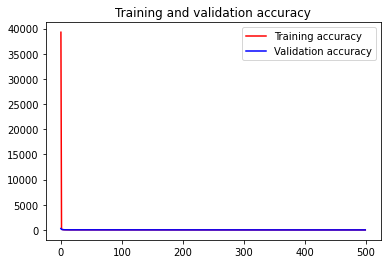

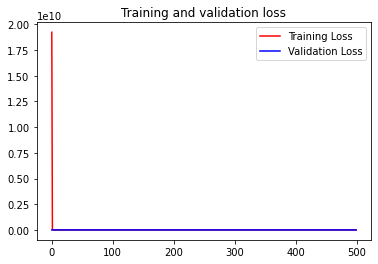

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('acc.png')

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
print(min(acc),max(acc))

6.5584736 39280.54
